In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/'
stispath = '{}stis/'.format(path)
cospath = '{}cos/'.format(path)

In [3]:
x1ds = np.hstack((glob.glob('{}*0_x1d.fits'.format(stispath)), glob.glob('{}*sx1.fits'.format(stispath))))#, glob.glob('{}*x1dsum.fits'.format(path))))
x1ds


array(['/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits'],
      dtype='<U70')

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits
G140M
[173.27858]


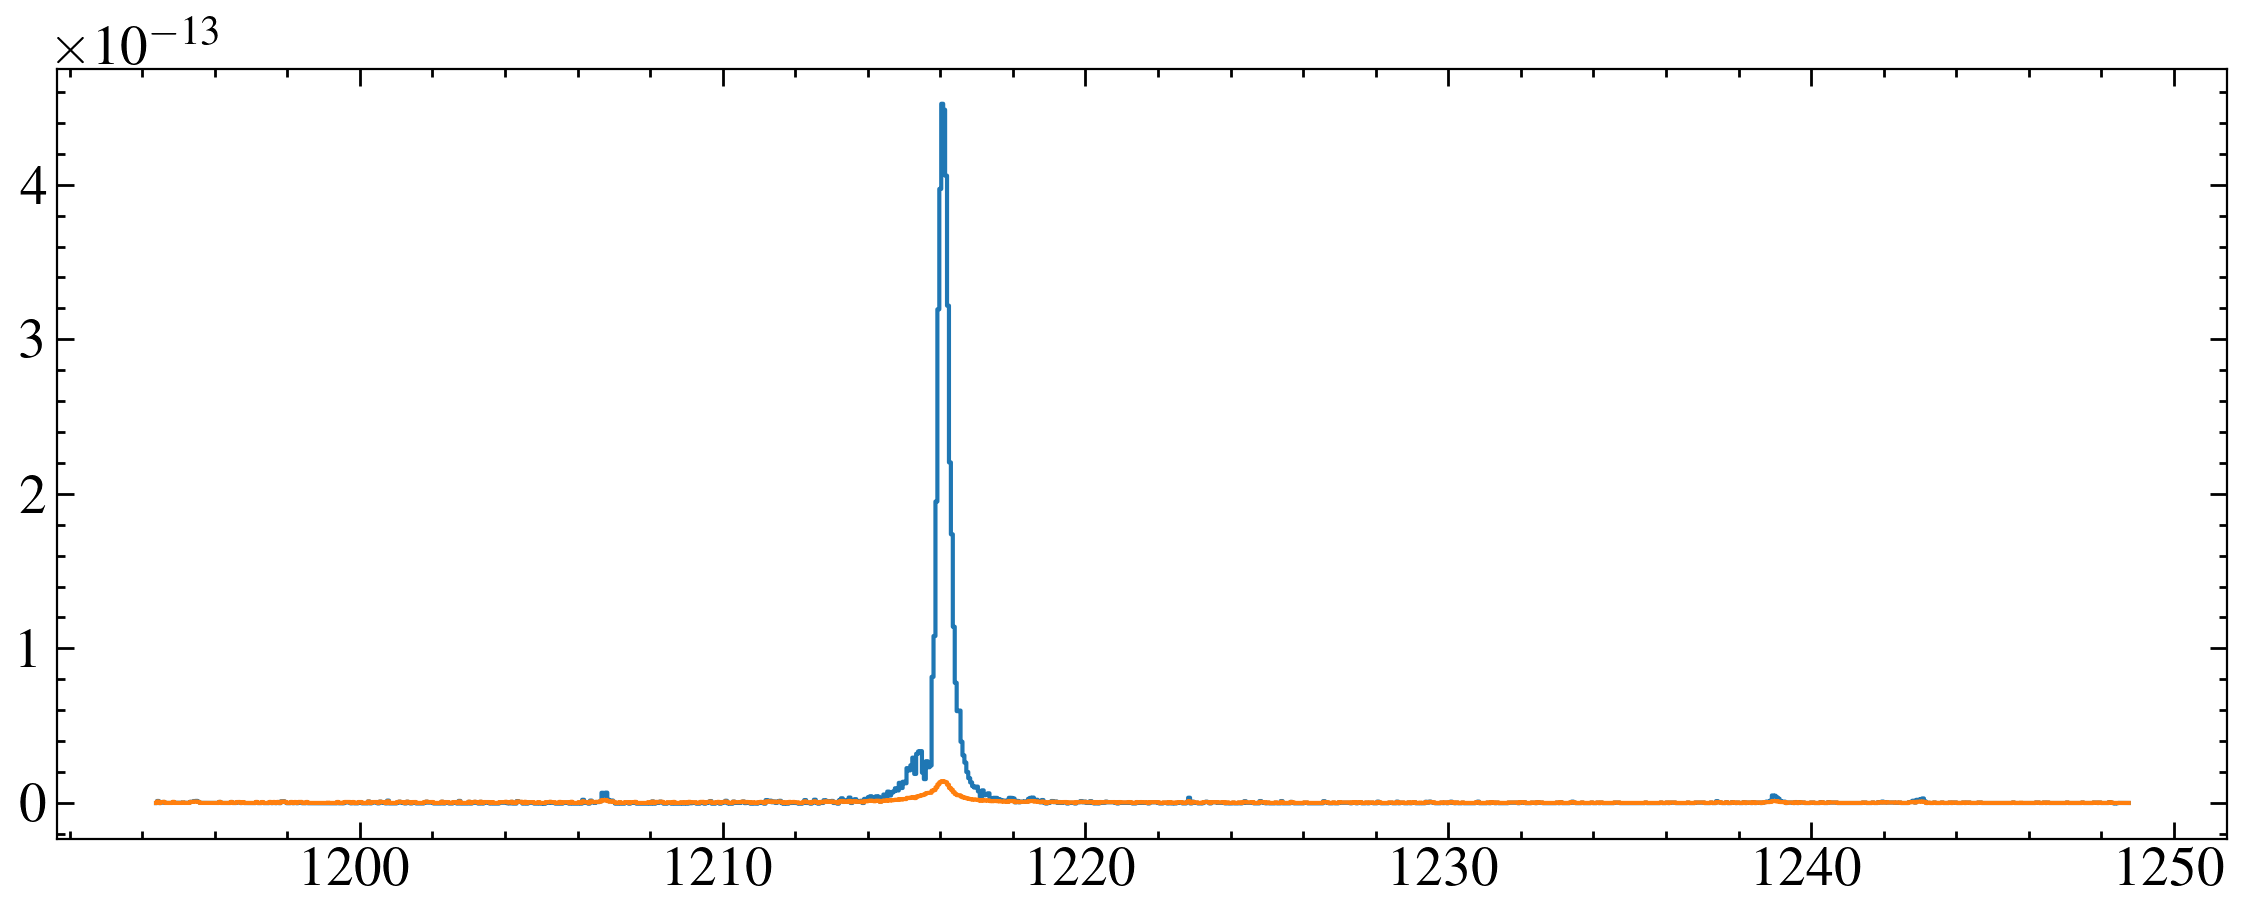

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits
G230L
[528.51666]


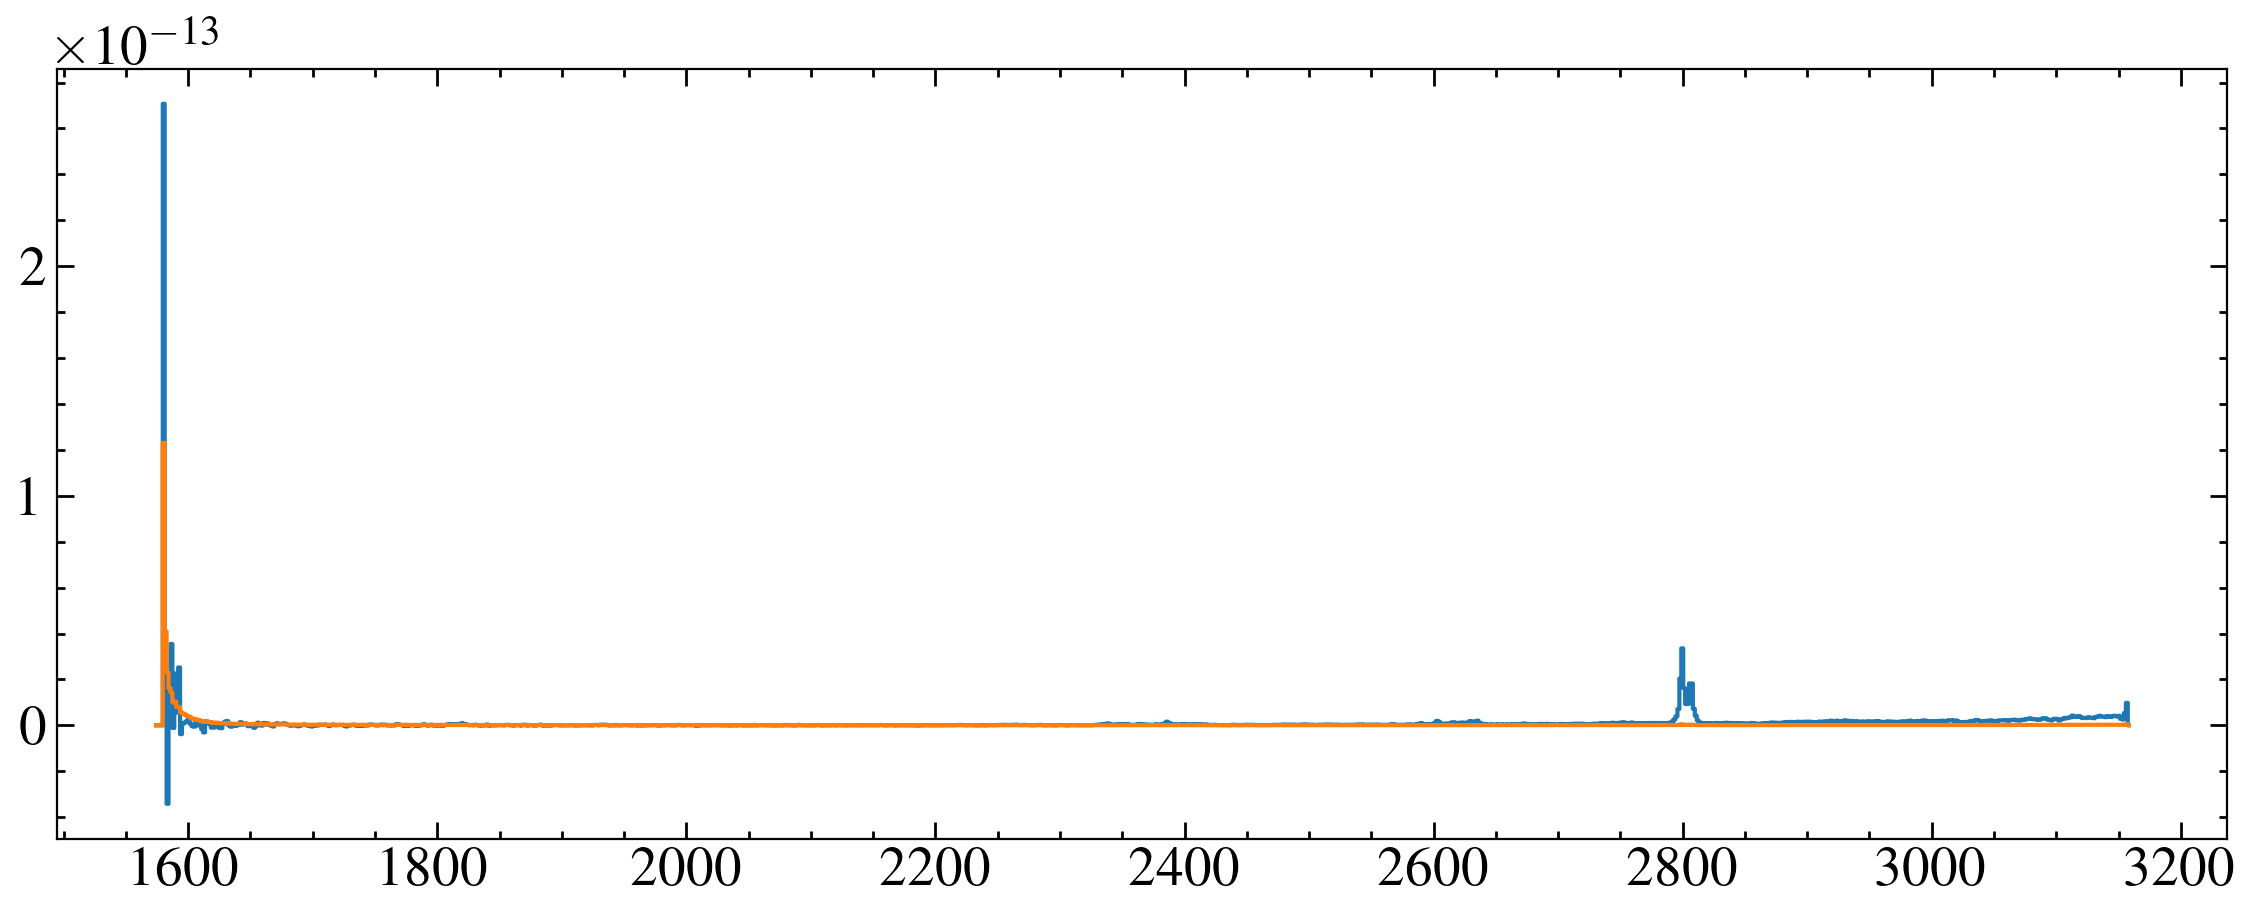

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits
G430L
[894.6452]


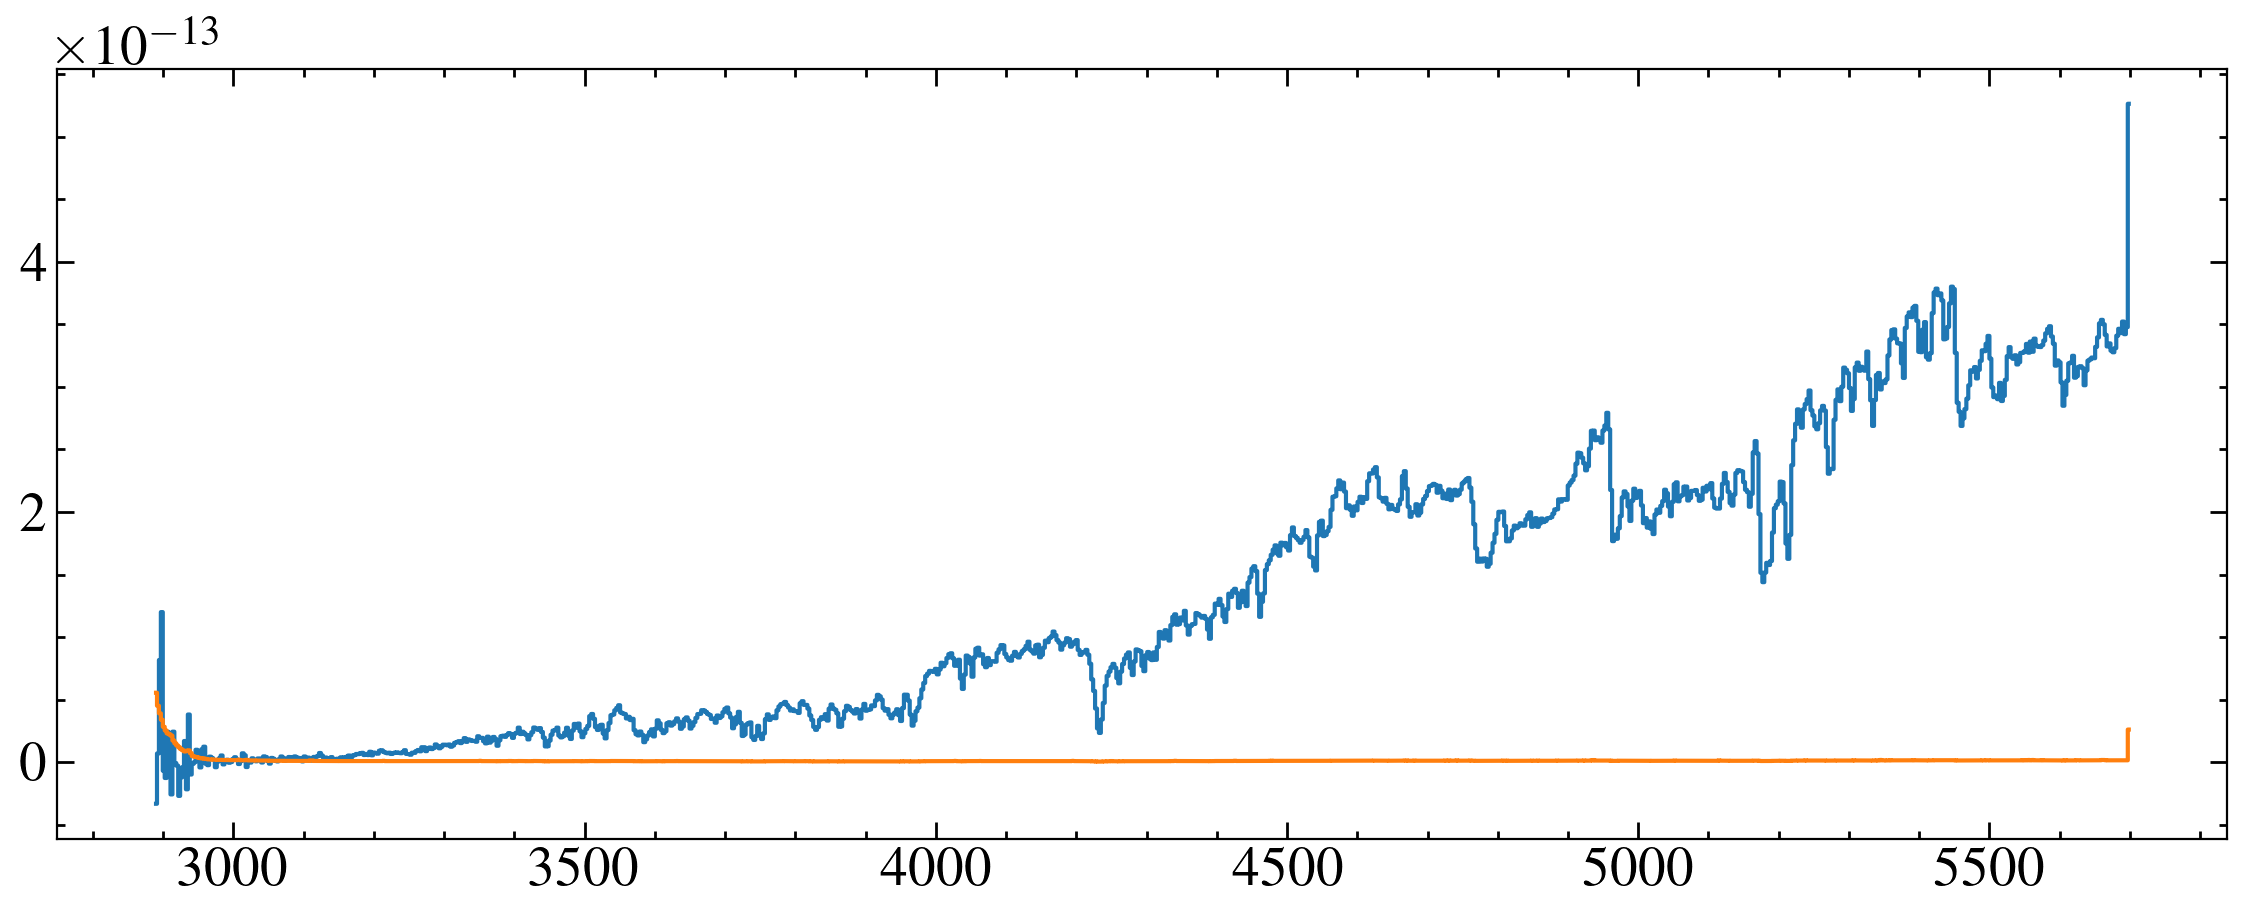

In [4]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()

    

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits
G140M
173.27858
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits
G230L
528.51666
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits
G430L
894.6452


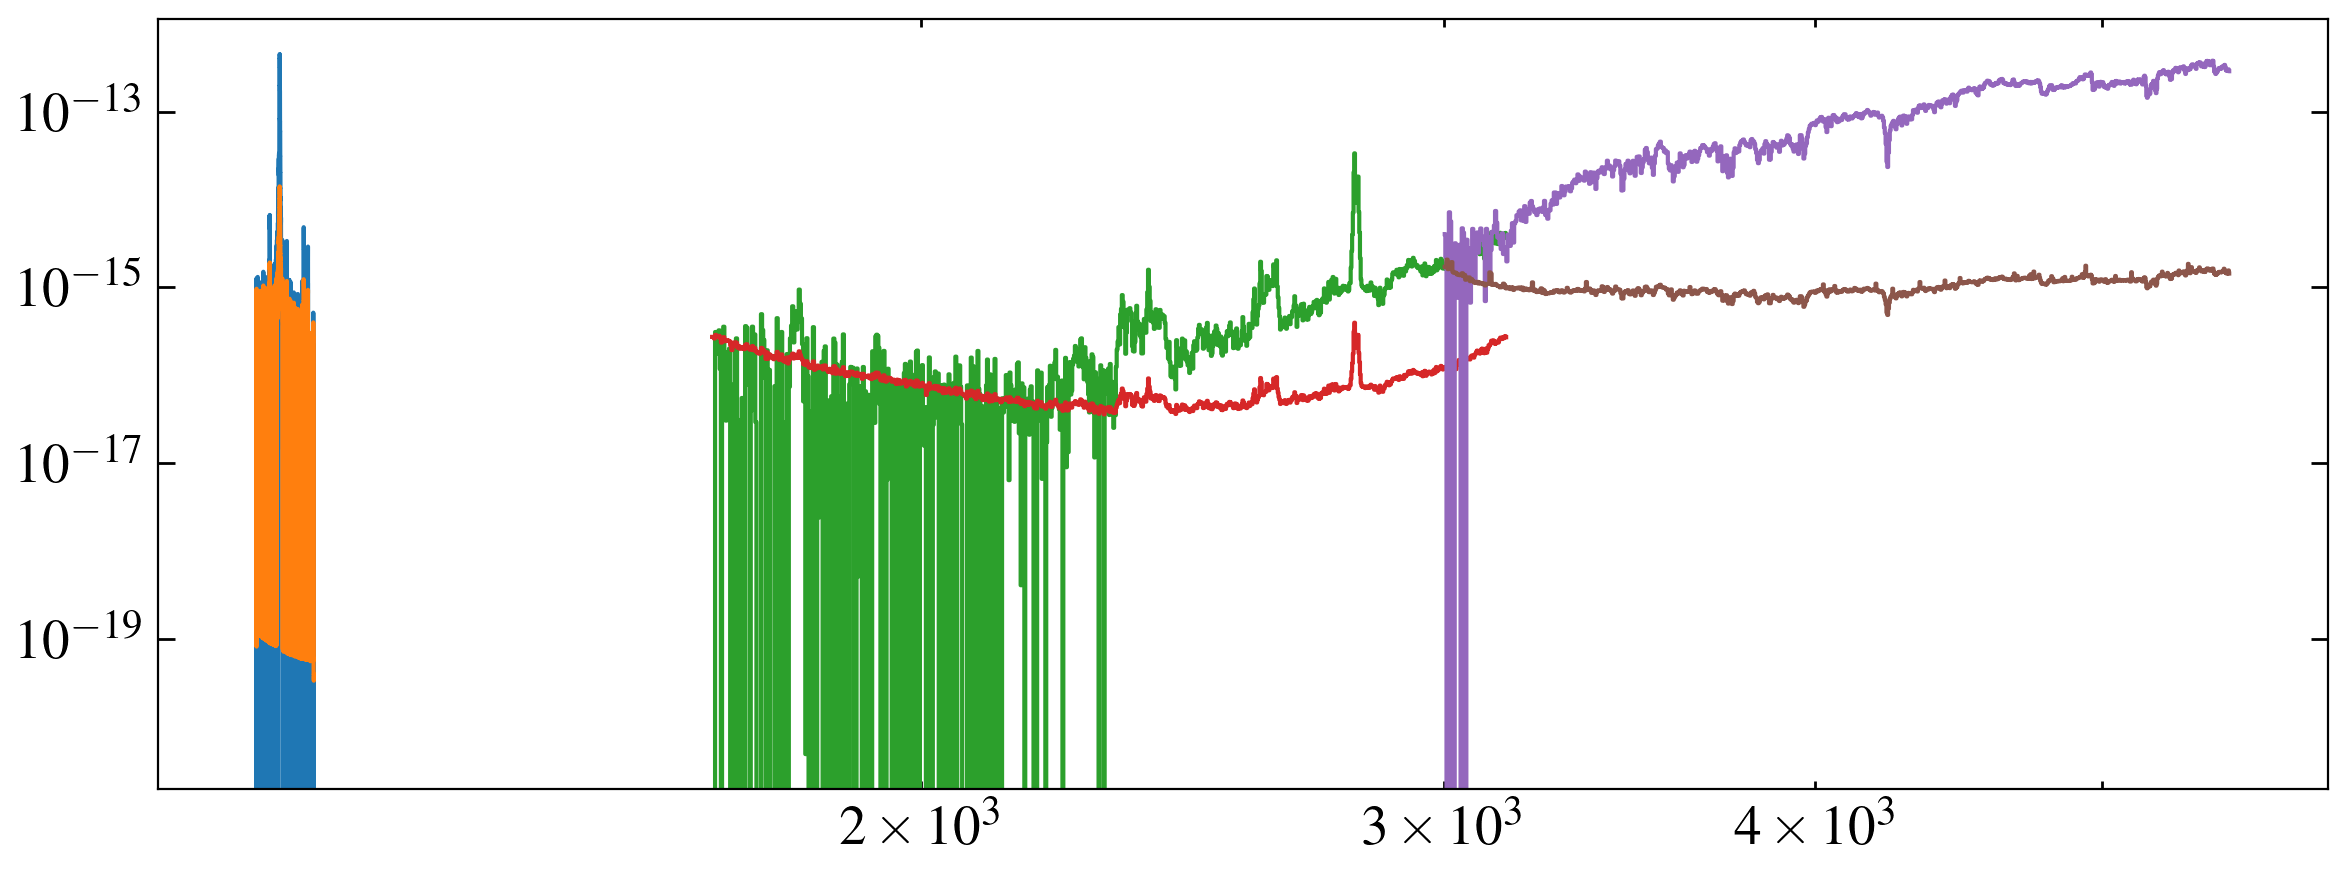

In [5]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
#     plt.show()
    
plt.yscale('log')
plt.xscale('log')

STIS all looks good. Rest of the data is COS - need to update prepare_cos for Meats

In [6]:
import importlib
import prepare_stis
importlib.reload(prepare_stis)

<module 'prepare_stis' from '/home/david/work/meats/SEDs/prepare_stis.py'>

/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/astropy/stats/funcs.py:699: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]


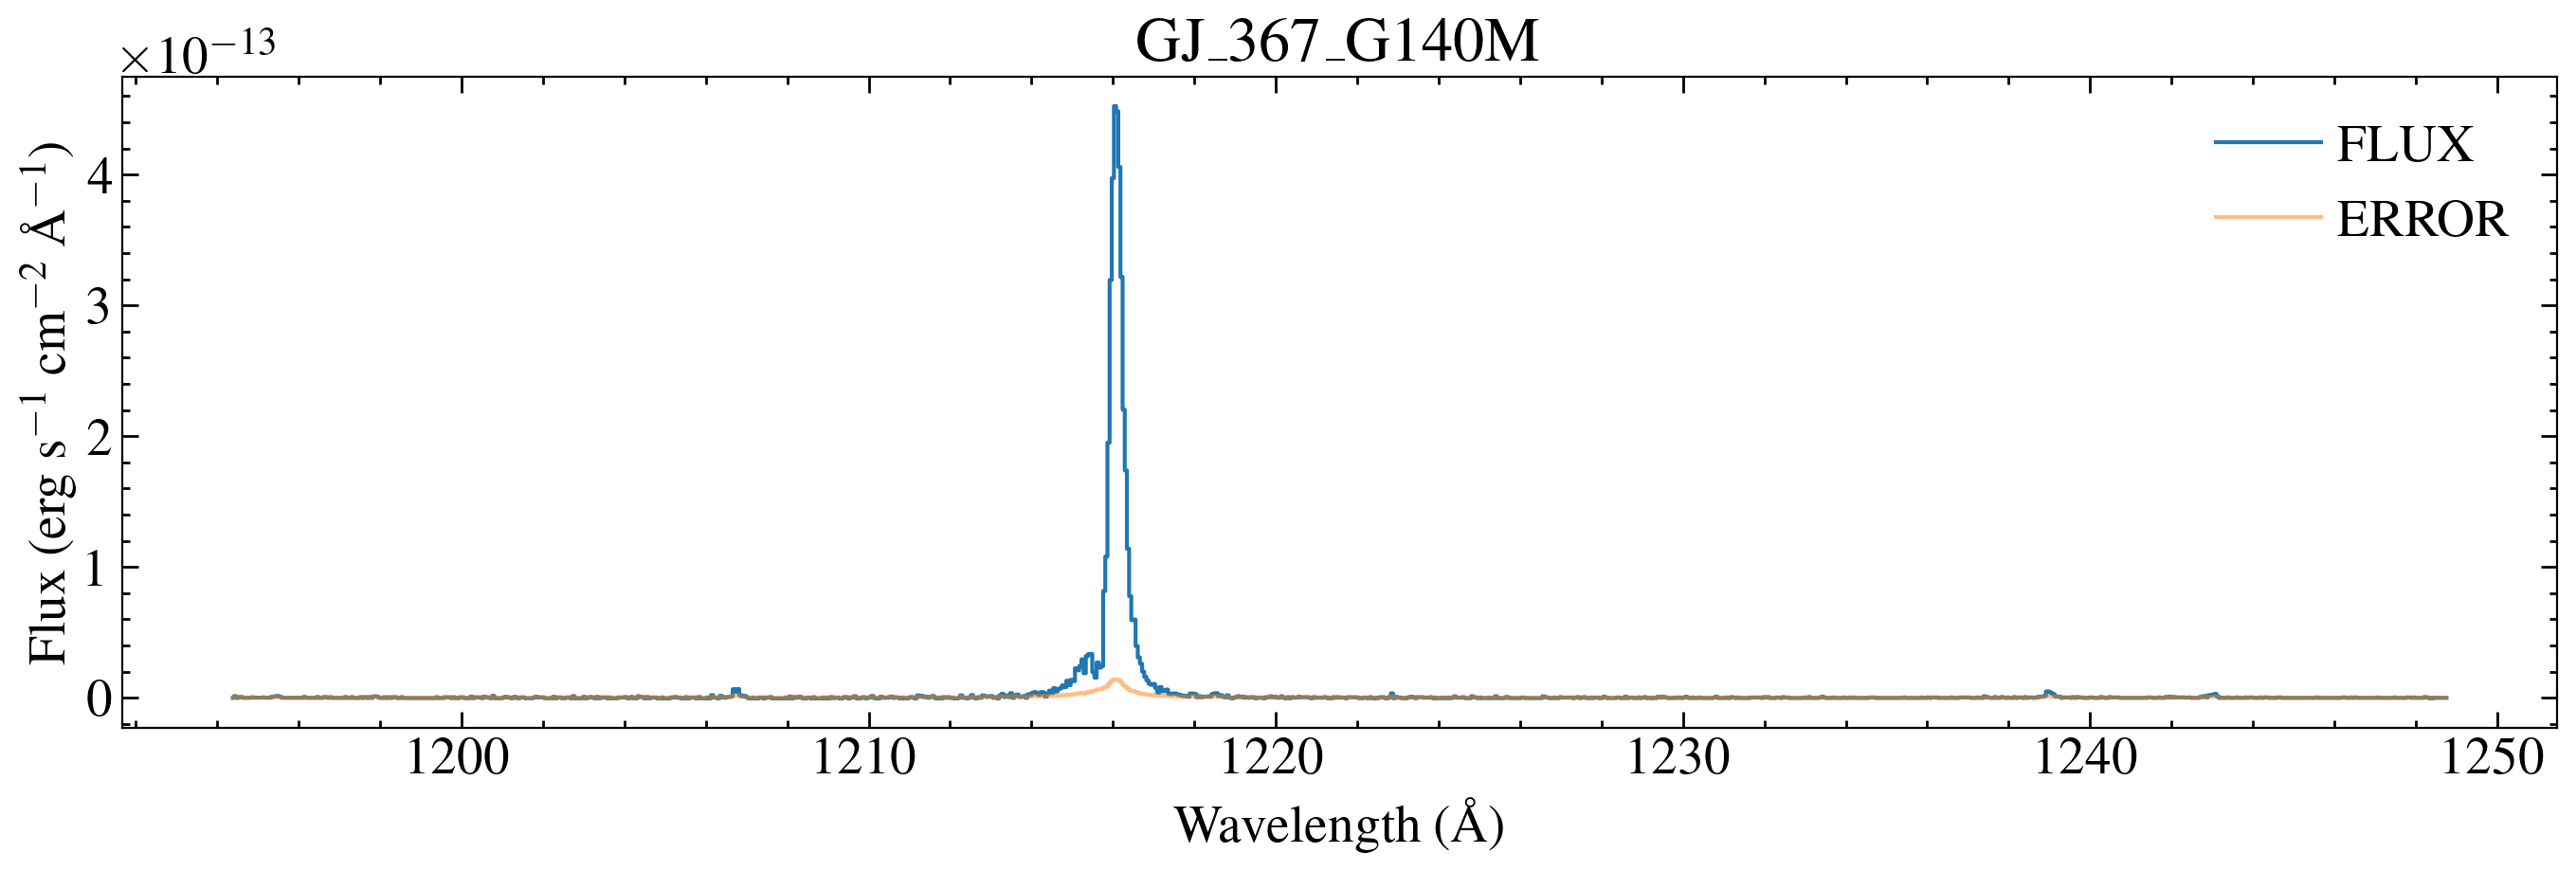

Spectrum saved as hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits


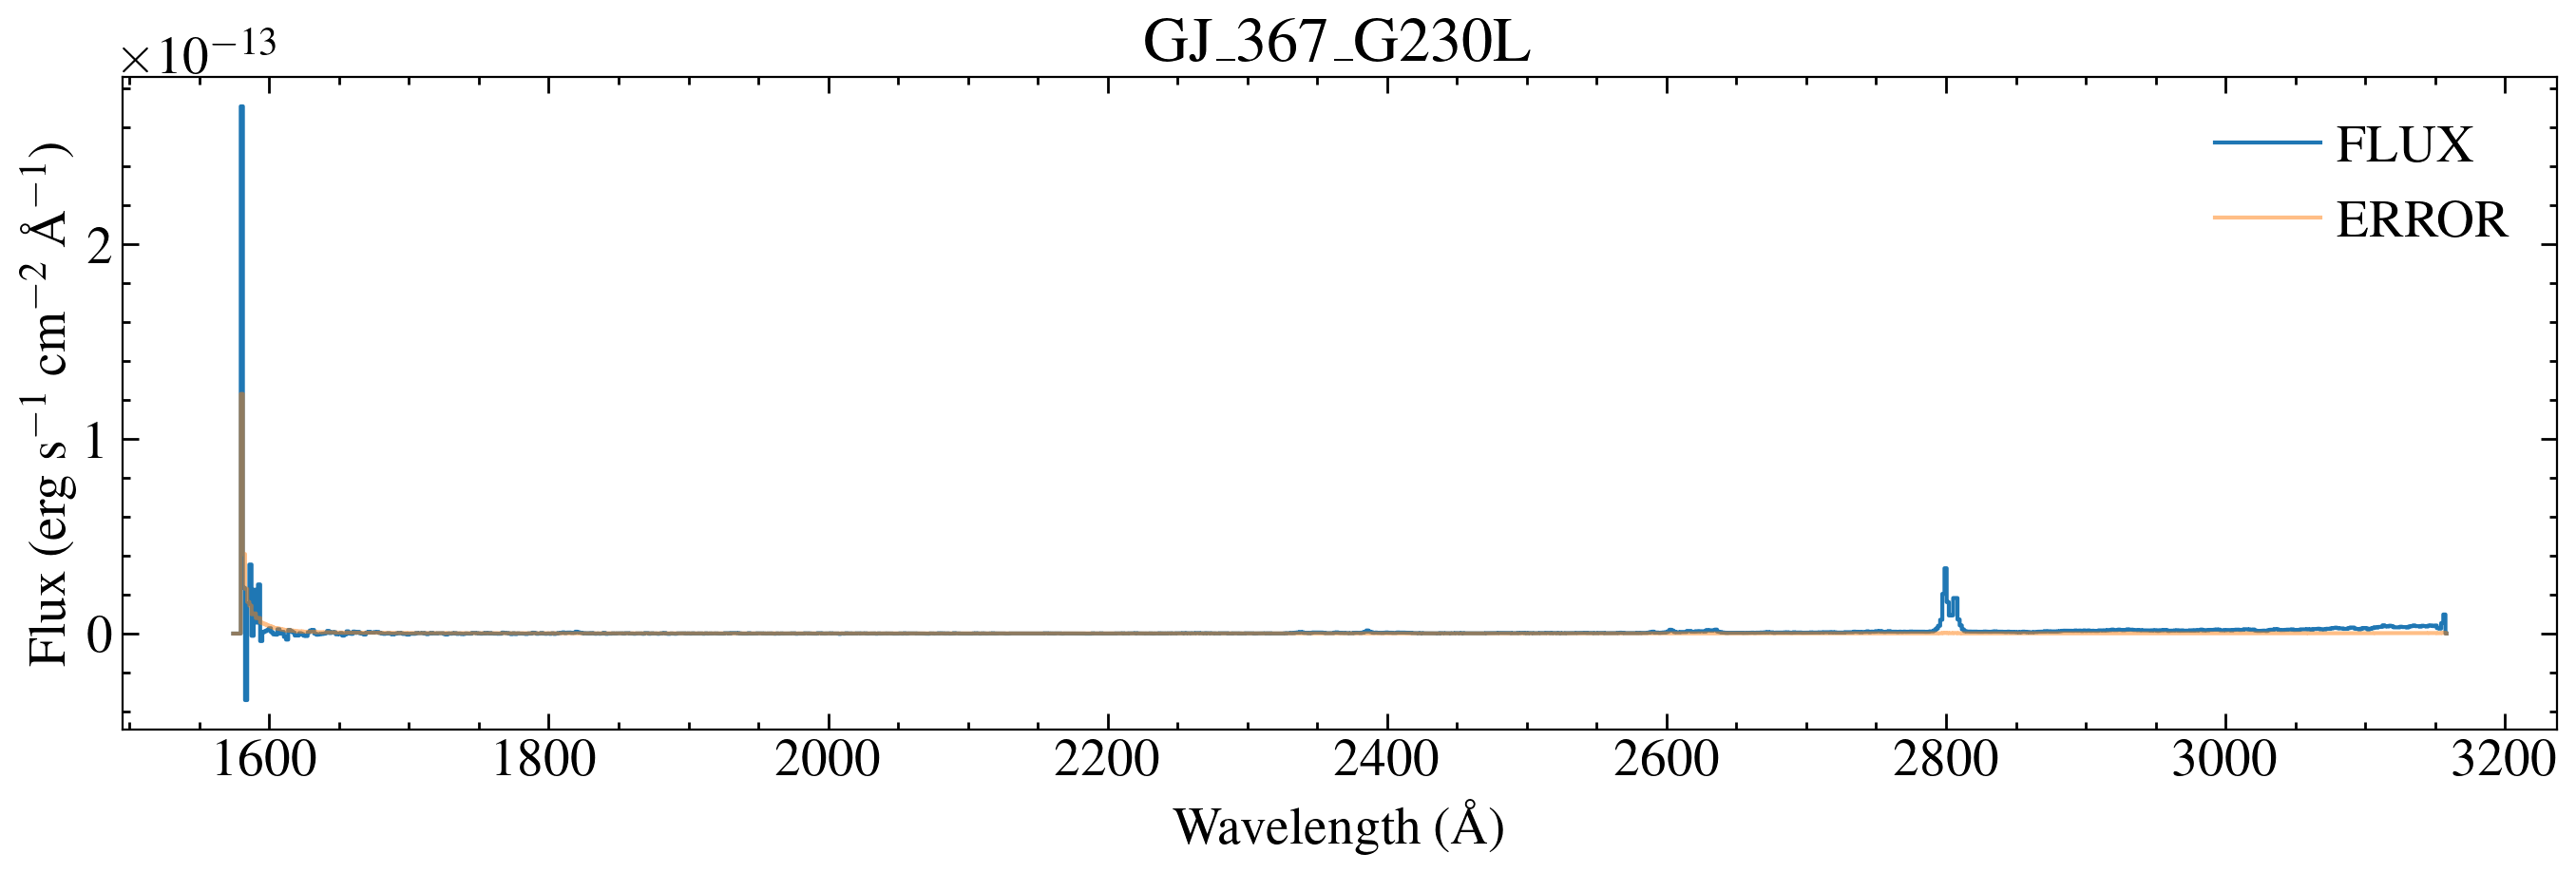

Spectrum saved as hlsp_muscles_hst_stis_gj_367_g230l_v1_component-spec.fits


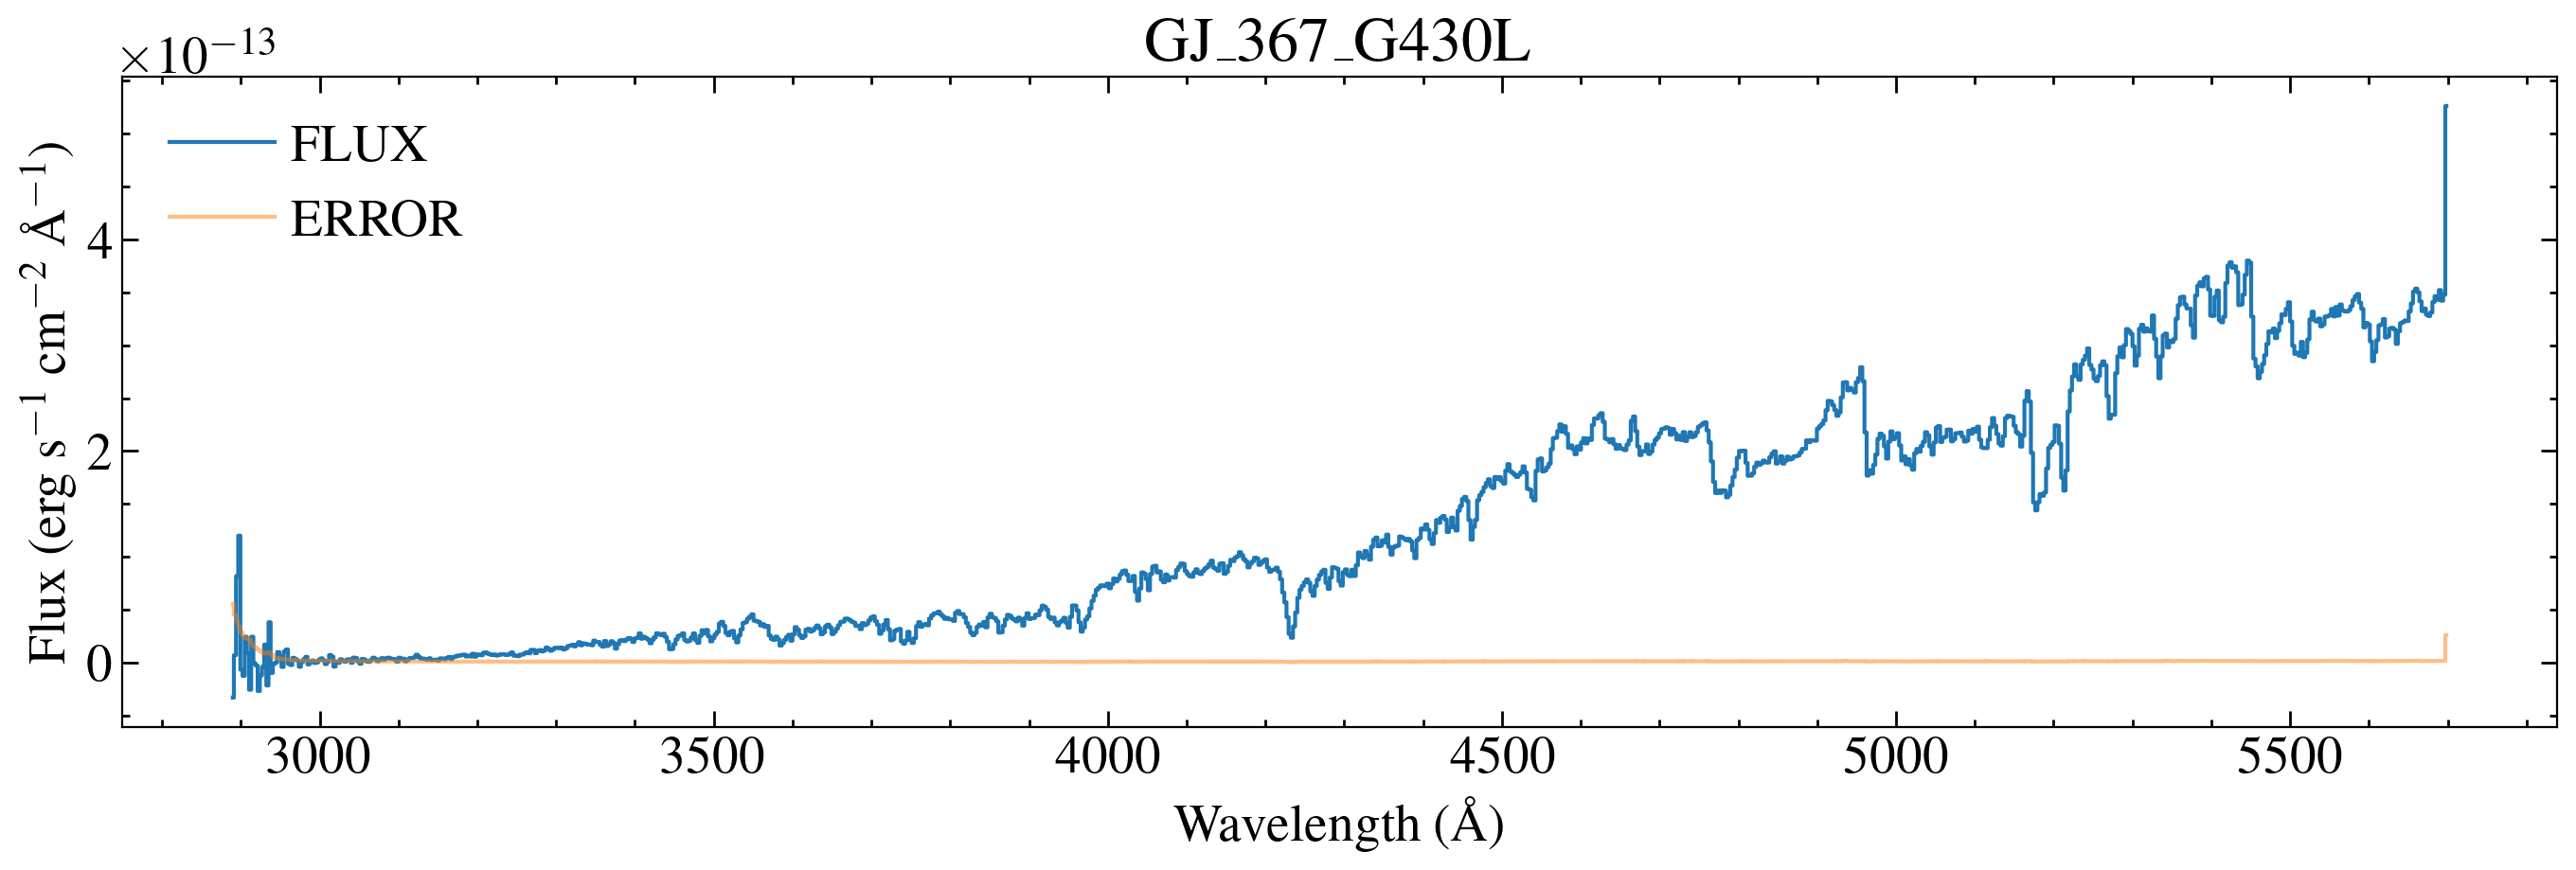

Spectrum saved as hlsp_muscles_hst_stis_gj_367_g430l_v1_component-spec.fits


In [7]:
x1dpath = stispath
savepath = 'draft_hlsp/gj_367/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'GJ_367')

In [8]:
import prepare_phoenix_svo as pp
importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.454
teff = 3522
teff_e = 70

radius = 0.457
distance = 9.42

save_path = 'models/'
star = 'GJ_367'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.777
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [9]:
hlsp_x1ds = glob.glob('draft_hlsp/gj_367/*stis*.fits')
hlsp_x1ds

['draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g430l_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g230l_v1_component-spec.fits']

draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits
draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g230l_v1_component-spec.fits


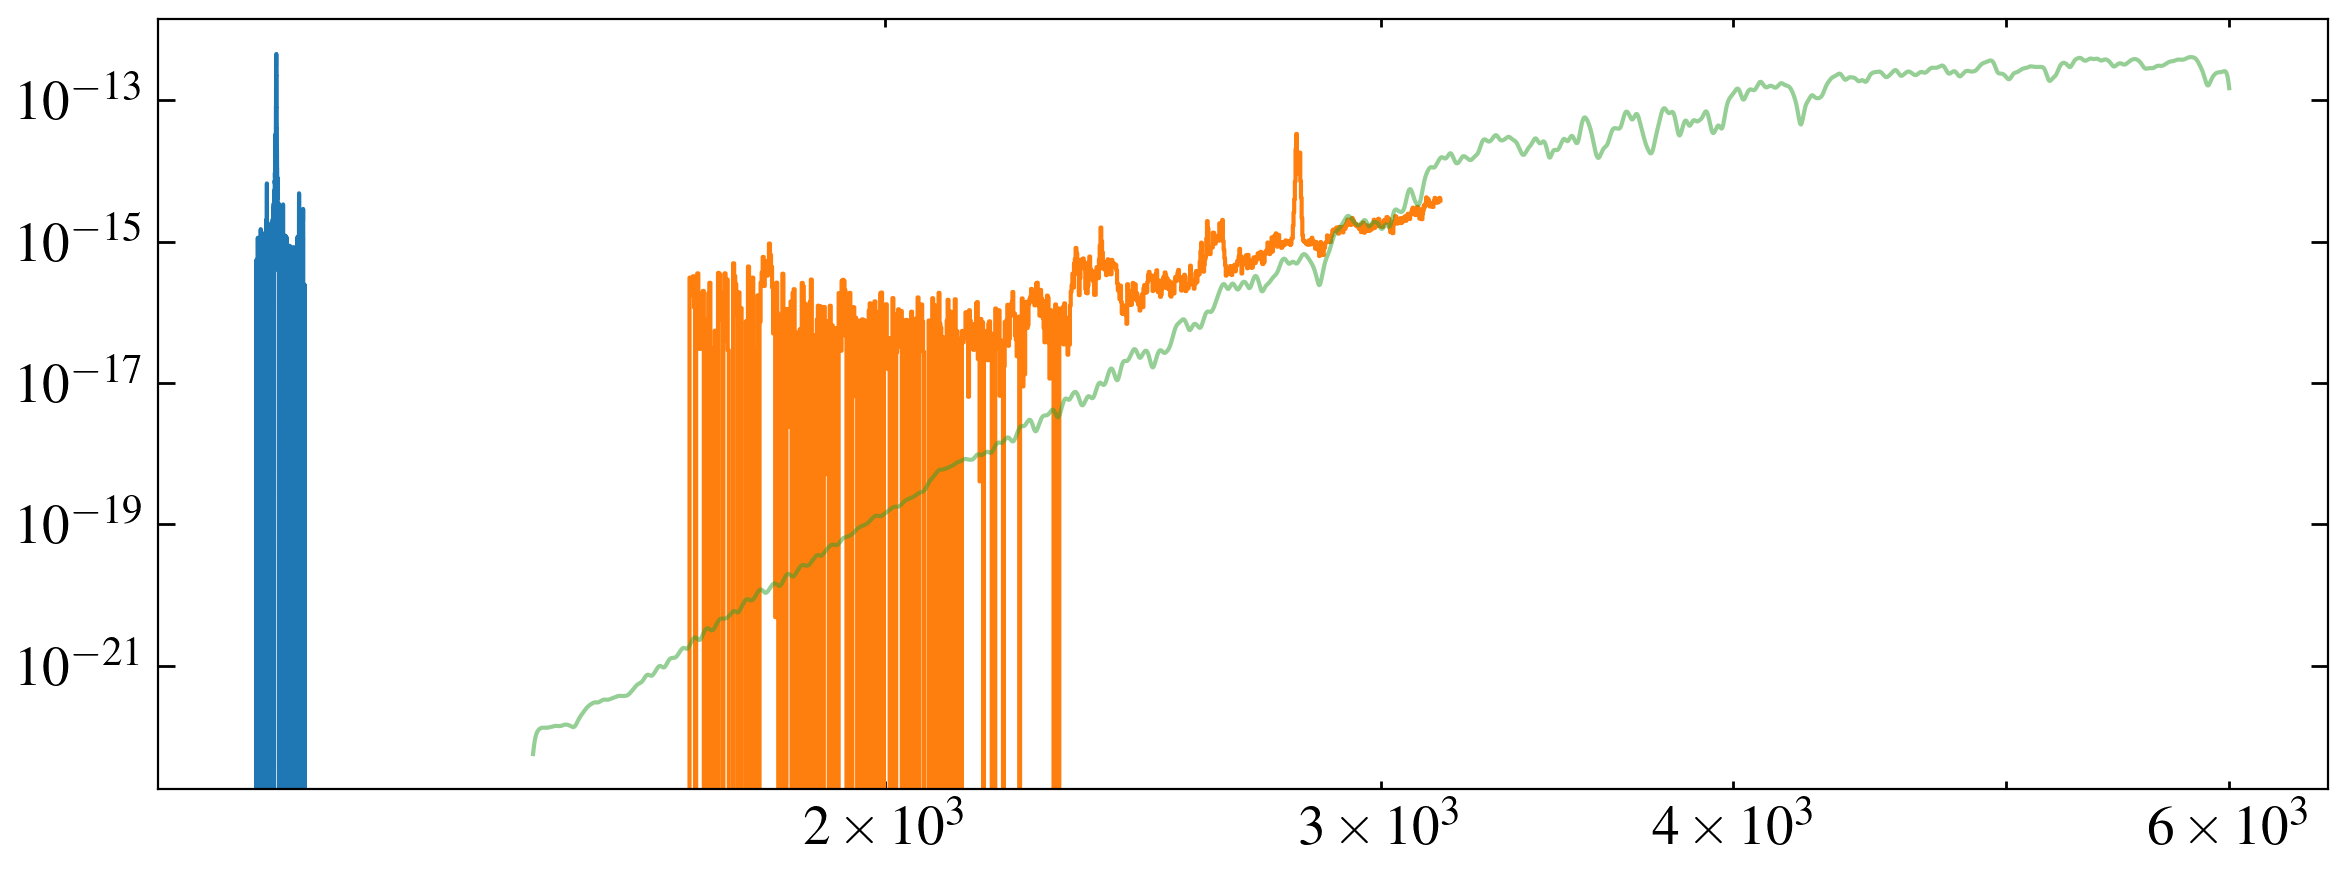

In [10]:
for x in hlsp_x1ds[1:]:
    print(x)
    grating = fits.getheader(x, 0)['GRATING'] 
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
#     plt.step(w, e, where='mid')
#     plt.show()
   
pmask = (pw > 1500) & (pw < 6000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi,500)
plt.plot(pwi, pfi, alpha=0.5)
    
plt.yscale('log')
plt.xscale('log')

Can live with that given the opacity problem. Kevin has made the data into a txt file, may need to re-write prepare cos...

In [11]:
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/cos/leoo04010_x1dsum.fits'
xdata = fits.getdata(x1dpath, 1)

cdata = Table.read('cos_files/gj367/GJ367_COS130M_NoSCL_Mm1_17aug2023.txt', format='ascii.basic')

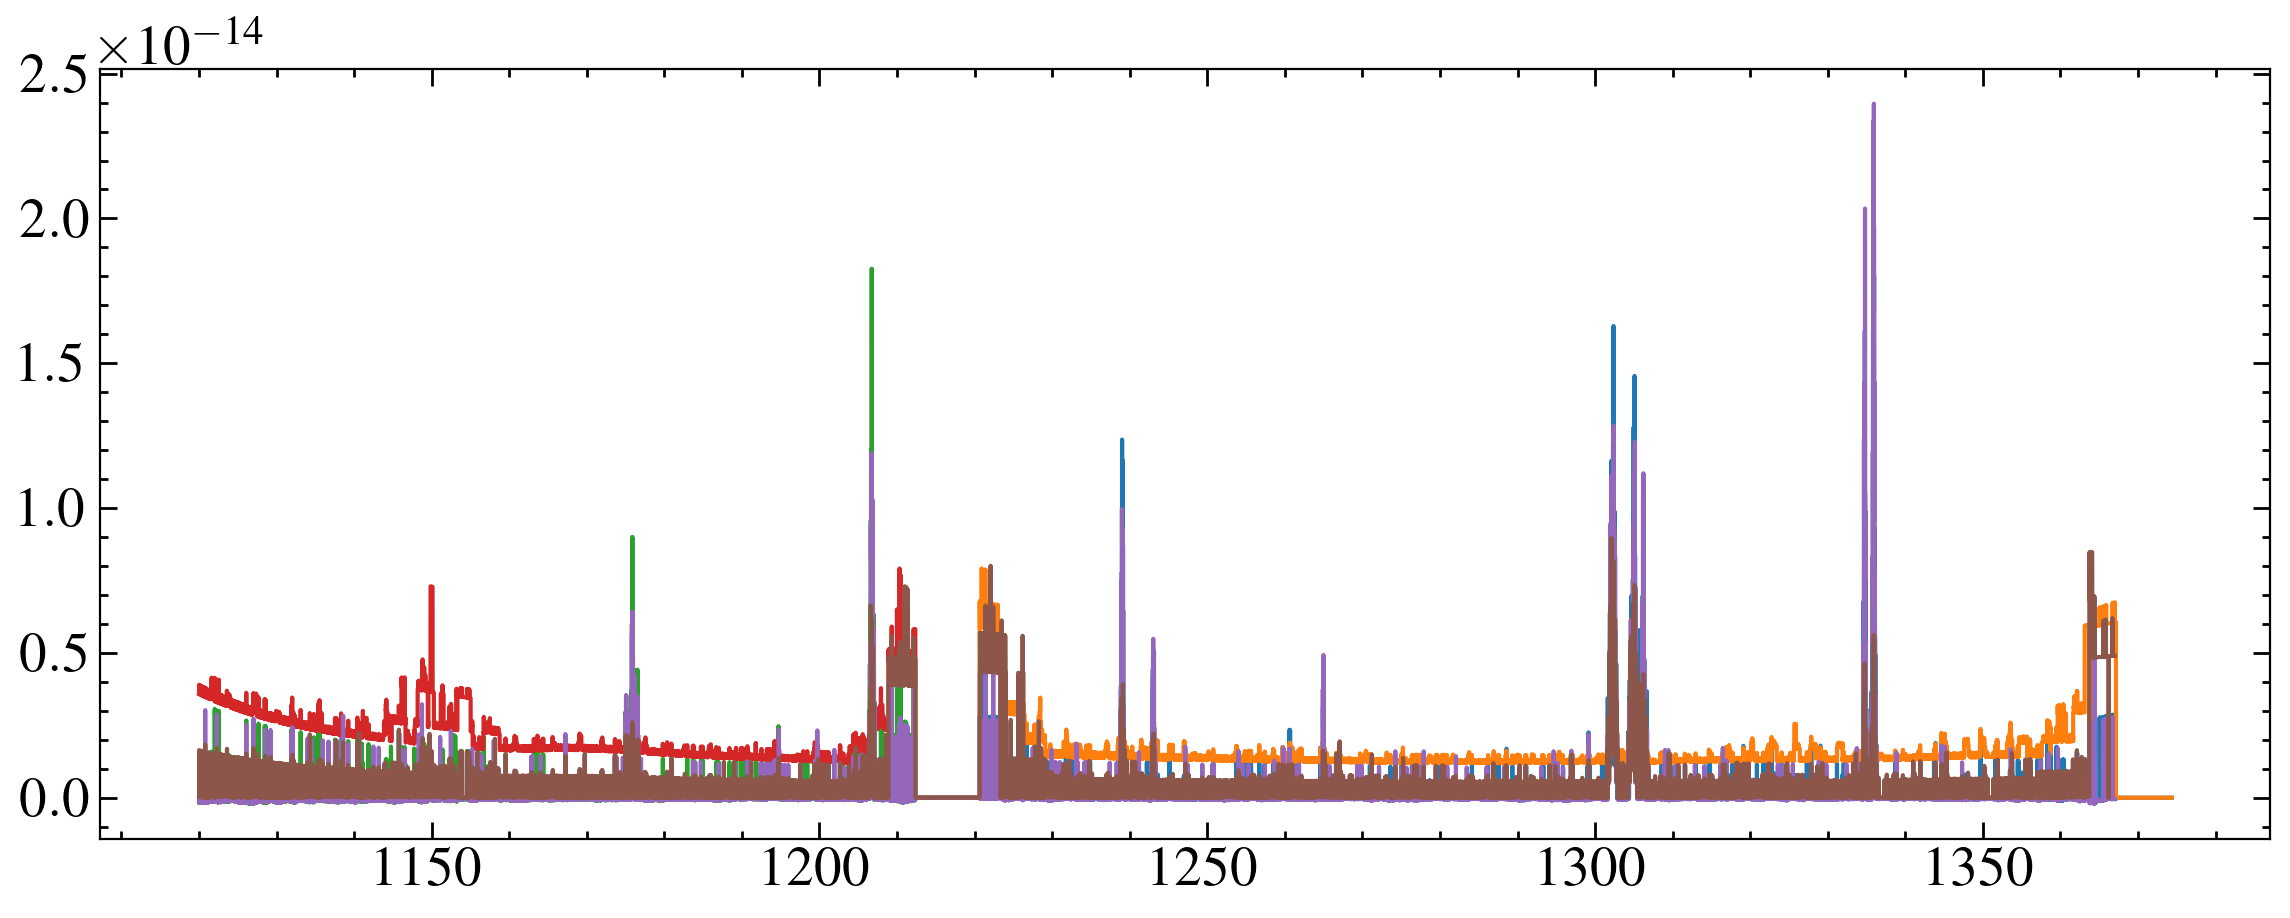

In [12]:
for dt in xdata:
    mask = dt['WAVELENGTH'] > 1120

    plt.step(dt['WAVELENGTH'][mask], dt['FLUX'][mask], where='mid')
    plt.step(dt['WAVELENGTH'][mask], dt['ERROR'][mask], where='mid')

mask = cdata['WAVELENGTH'] > 1120
plt.step(cdata['WAVELENGTH'][mask], cdata['FLUX'][mask], where='mid')
plt.step(cdata['WAVELENGTH'][mask], cdata['ERROR'][mask], where='mid')

In [13]:
xdata['WAVELENGTH']

array([[1211.12701601, 1211.13697905, 1211.14694209, ..., 1374.33157688,
        1374.34153992, 1374.35150296],
       [1058.11852785, 1058.12847907, 1058.13843029, ..., 1221.12944841,
        1221.13939963, 1221.14935084]], dtype='>f8')

In [14]:
np.hstack(xdata['WAVELENGTH'])

array([1211.12701601, 1211.13697905, 1211.14694209, ..., 1221.12944841,
       1221.13939963, 1221.14935084])

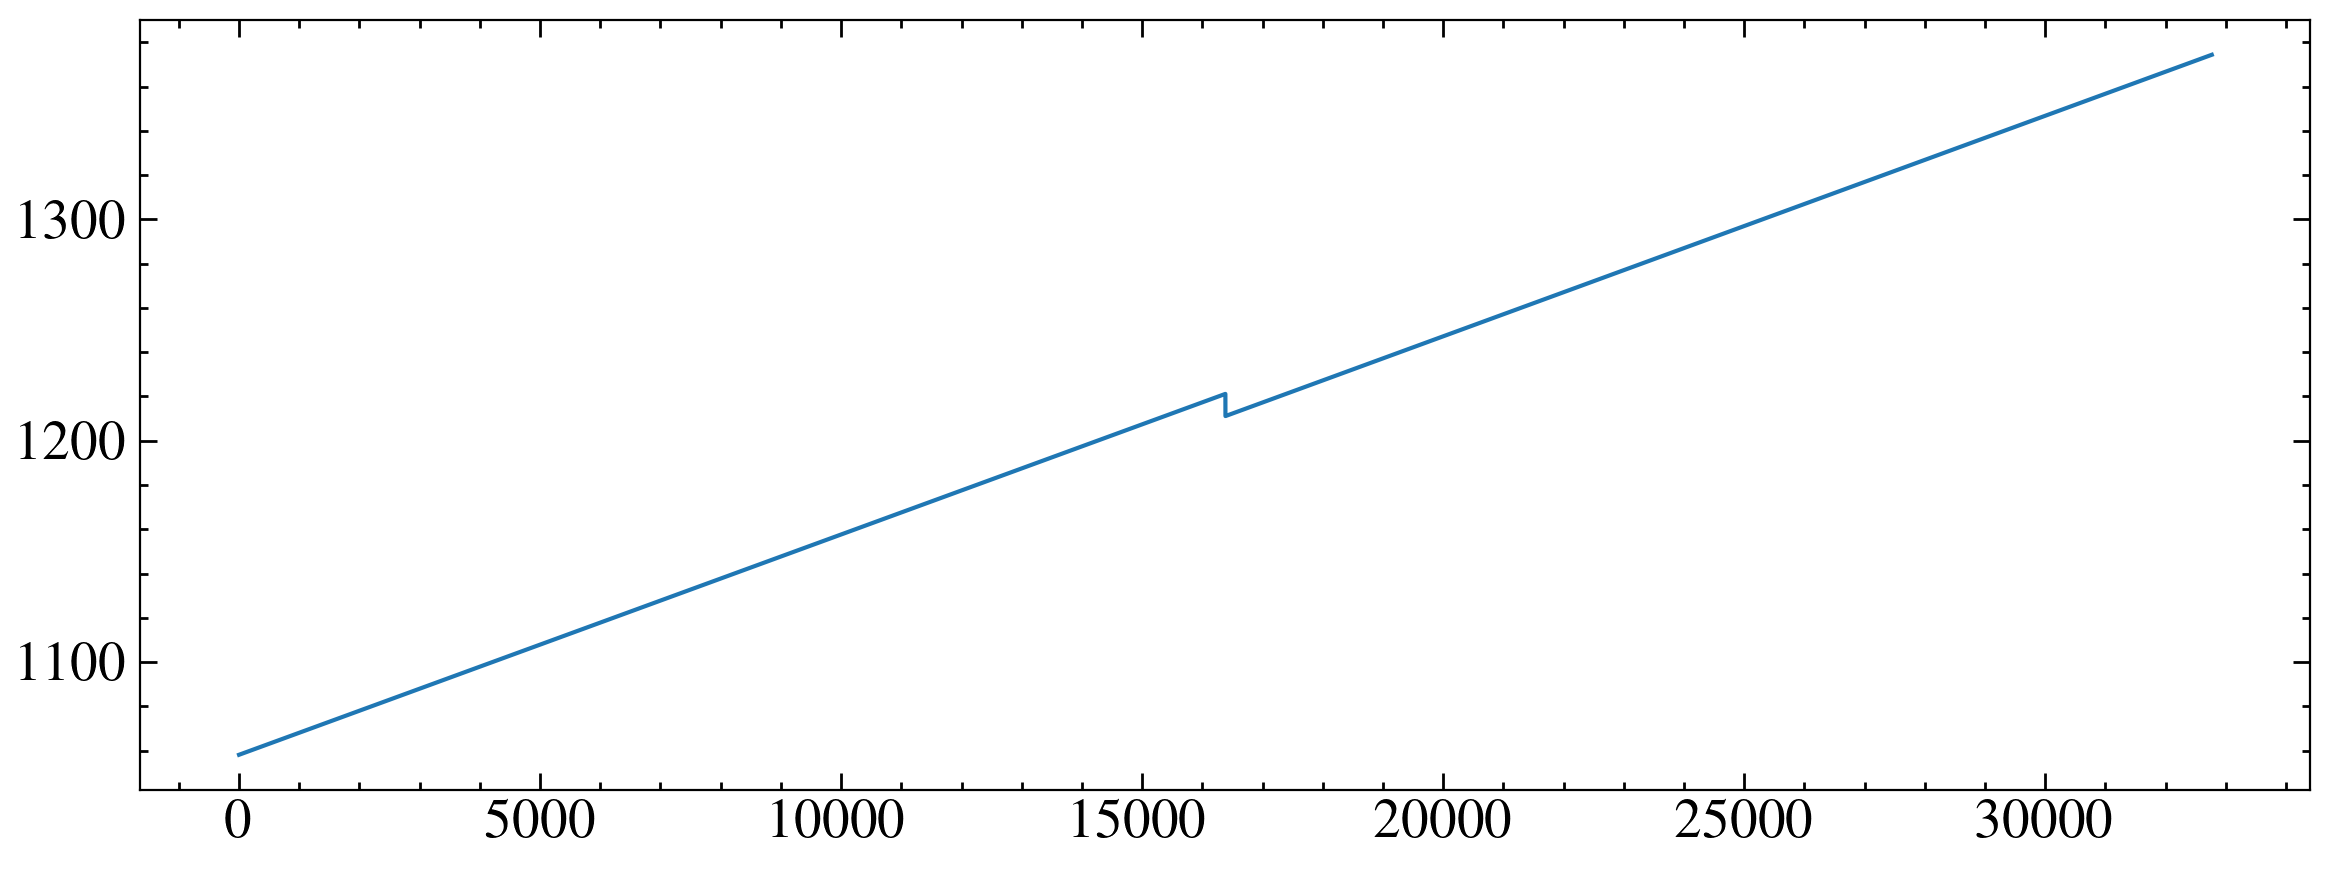

In [15]:
# plt.plot(np.hstack(xdata['WAVELENGTH'][::-1]), np.hstack(xdata['FLUX'][::-1]))
plt.plot(np.arange(len(np.hstack(xdata['WAVELENGTH']))), np.hstack(xdata['WAVELENGTH'][::-1]))

30291 30291 30291 30291
['/media/david/2tb_ext_hd/hddata/meats/hst/gj367/cos/leoo04010_x1dsum.fits']


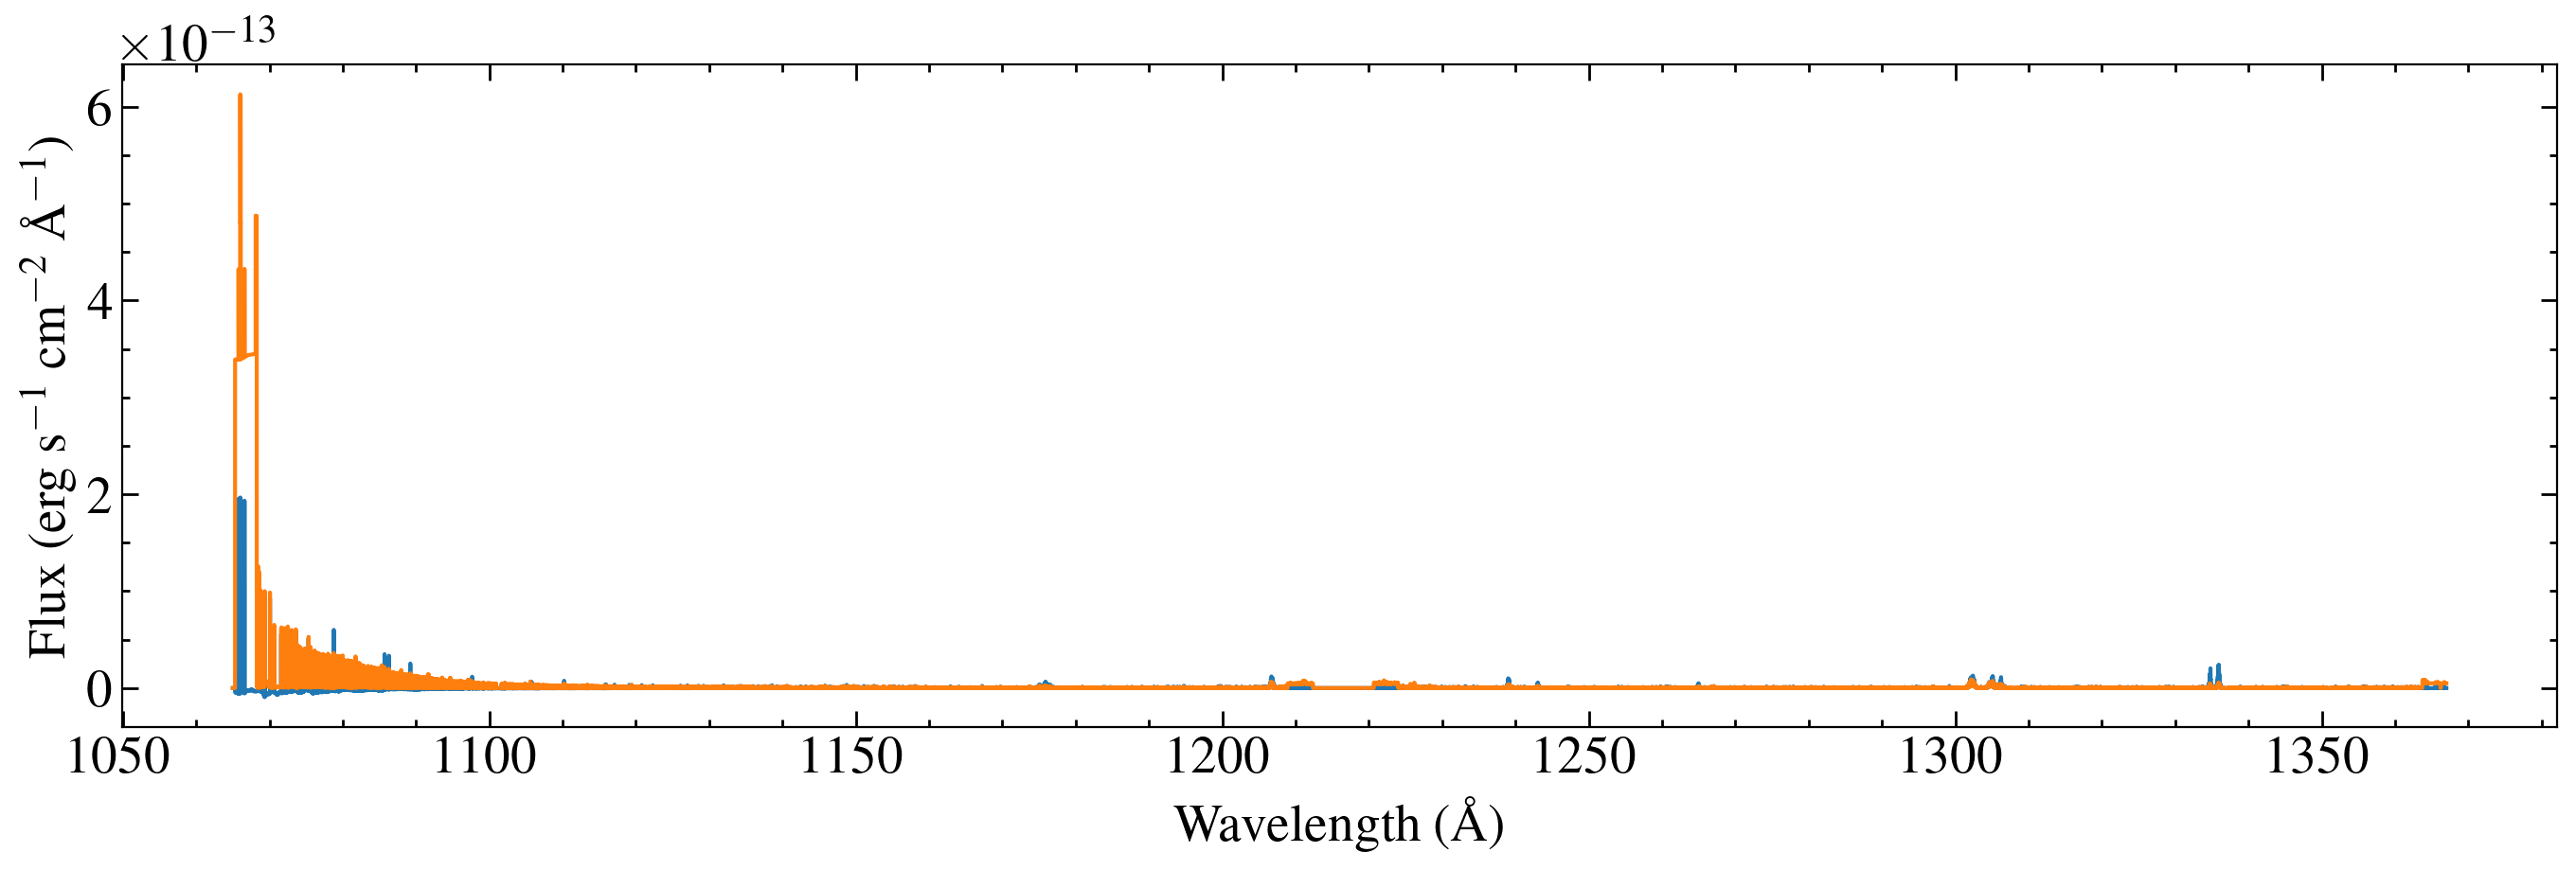

Spectrum saved as hlsp_muscles_hst_cos_gj_367_g130m_v1_component-spec.fits


In [87]:
import prepare_cos
importlib.reload(prepare_cos)

savpath = 'cos_files/gj367/GJ367_COS130M_NoSCL_Mm1_17aug2023.txt'
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/cos/'
hlsp = 'meats_hlsp_info.csv'
version = 1
savepath = 'draft_hlsp/gj_367/'
# star = 
prepare_cos.make_cos_spectrum(savpath, version, x1dpath, hlsp, savepath = savepath, plot=True, save_fits=True, star='GJ_367')

In [17]:
# hdr = fits.getheader('{}leoo04010_x1dsum.fits'.format(x1dpath), 0)
# hdr

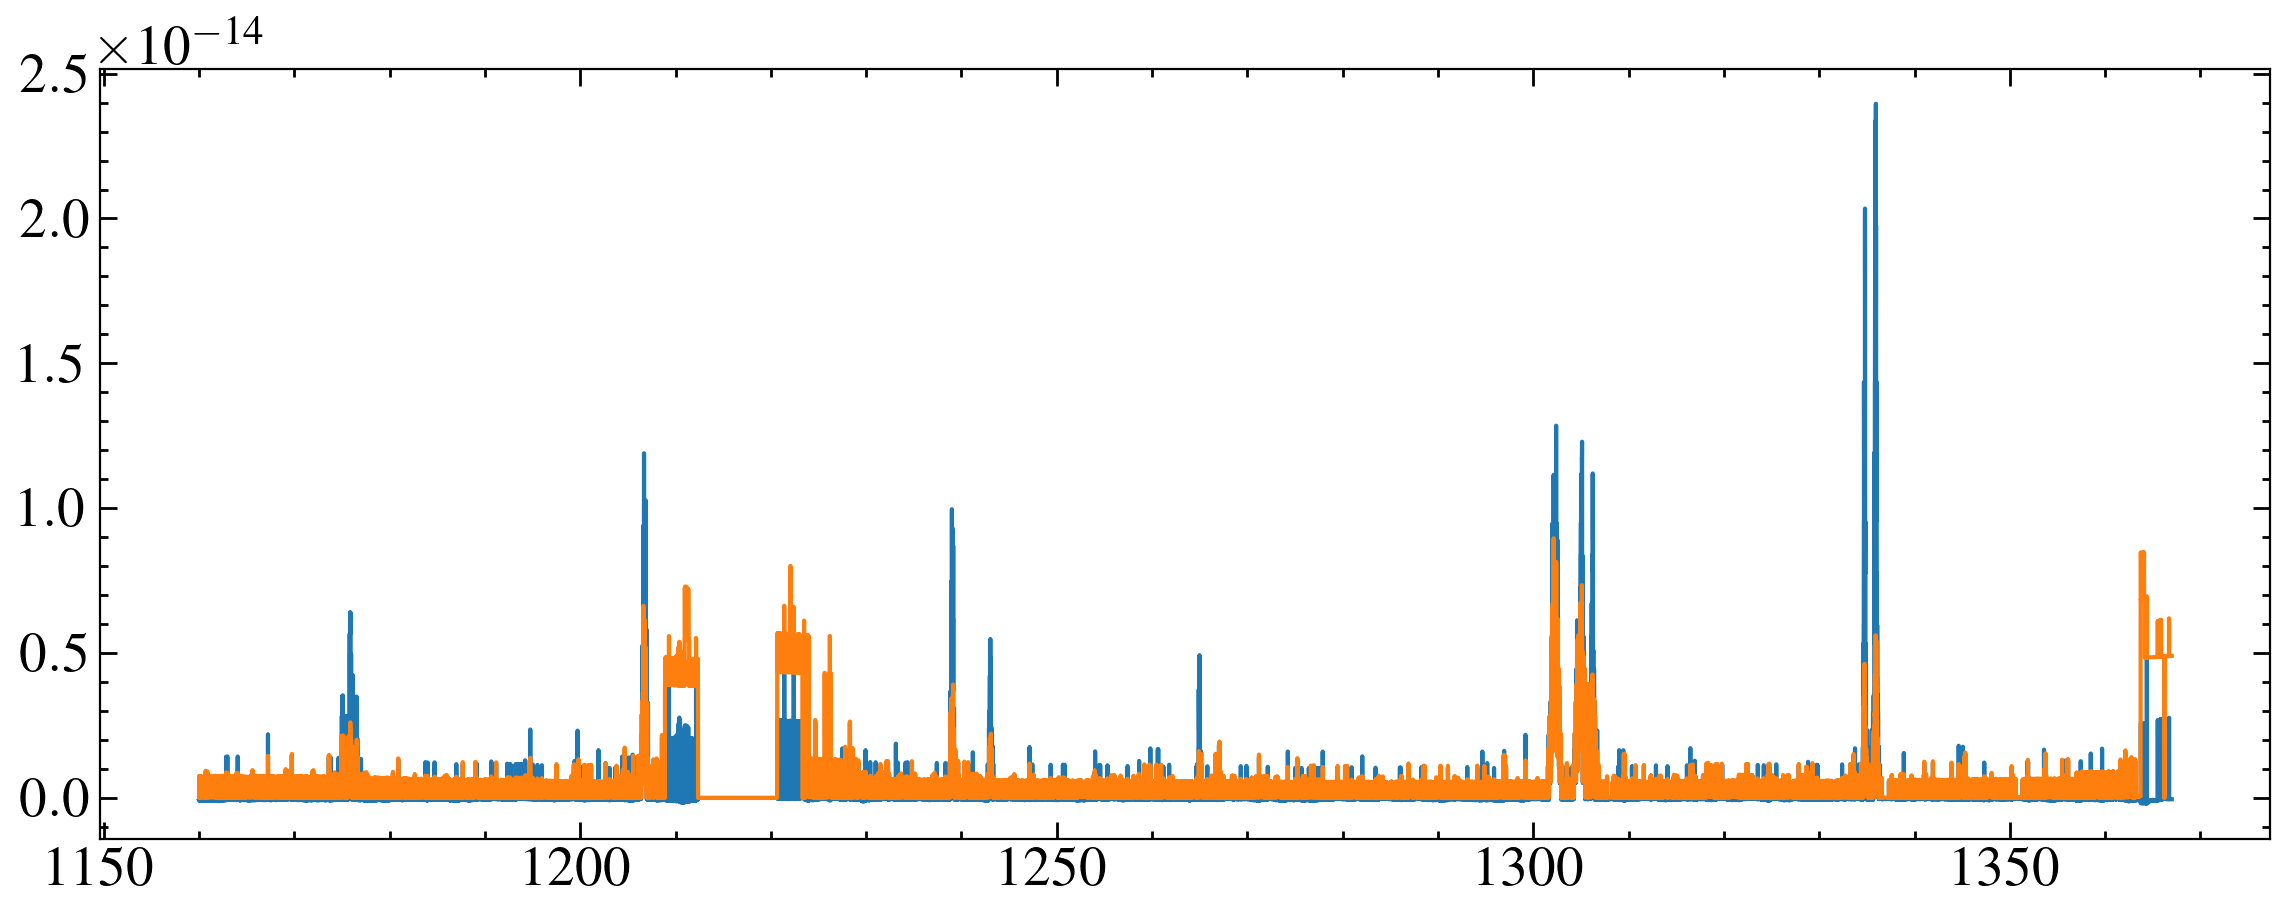

In [18]:
data = fits.getdata('draft_hlsp/gj_367/hlsp_muscles_hst_cos_gj_367_g130m_v1_component-spec.fits', 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1160
w, f, e = w[mask], f[mask], e[mask]
plt.step(w, f, where='mid', c='C0')
plt.step(w, e, where='mid', c='C1')

Light cuves

662759008.9181


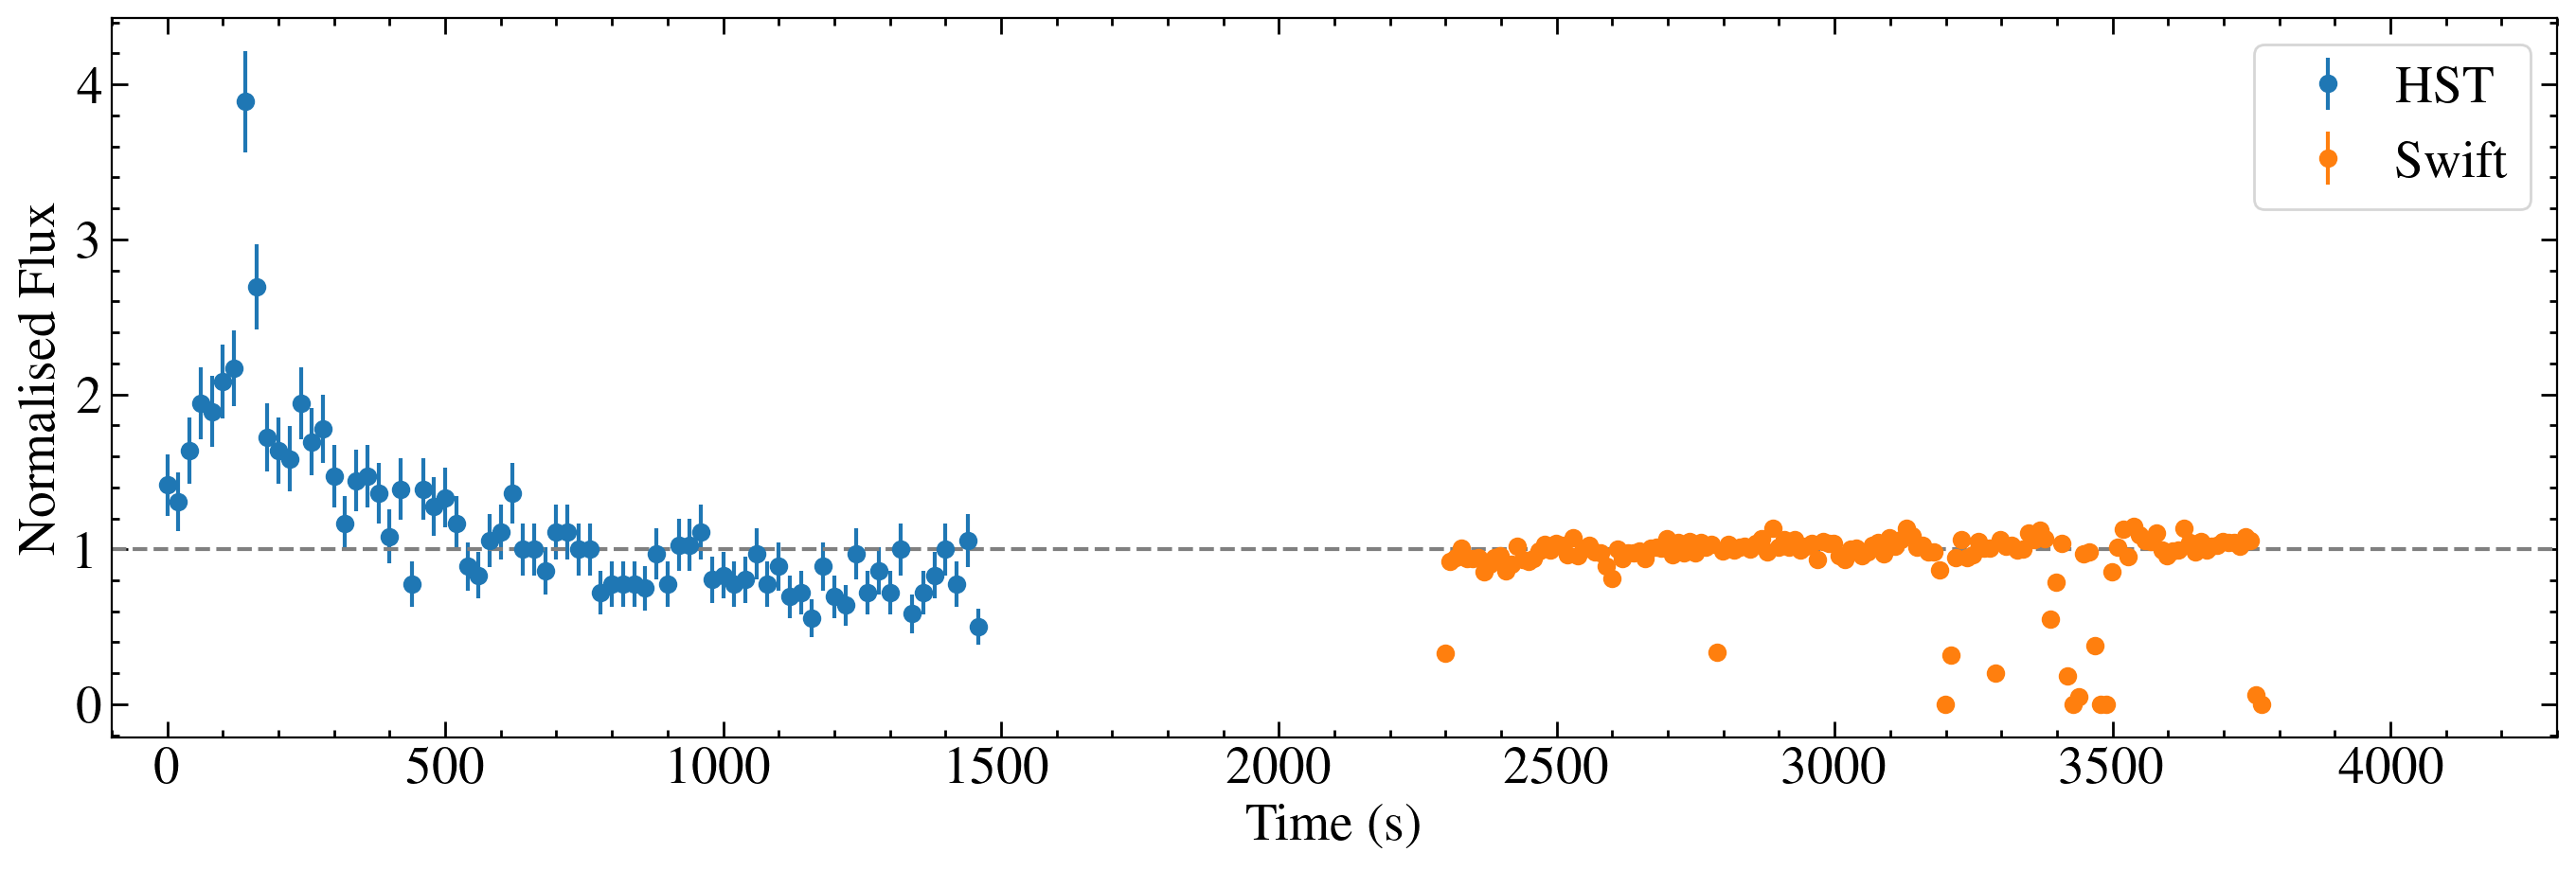

In [19]:
cos_start = 59580.796 #mjd
cos_lc = Table.read('cos_files/gj367/GJ367_COS130Mb_lightcurve.txt', format='ascii.basic')

norm = np.median(cos_lc['COUNTS'])
plt.errorbar(cos_lc['TIME'], cos_lc['COUNTS']/norm, yerr=cos_lc['ERROR']/norm, ls='none', marker='o', label='HST')

spath ='/media/david/2tb_ext_hd/hddata/meats/swift/gj367/working/'
swift_lcs = glob.glob('{}*u_10slc*.fits'.format(spath))

start_s = (cos_start-51910.00074287037)*86400

for lc in swift_lcs[1:]:
    data = fits.getdata(lc, 1)
    norm = np.median(data['AB_FLUX_AA'])
    print(data['TIME'][0])
    plt.errorbar(data['TIME']-start_s, data['AB_FLUX_AA']/norm, yerr= data['AB_FLUX_AA_ERR']/norm, ls='none', marker='o', label='Swift')
    
plt.xlim(-100, 4300)
plt.legend(frameon=True)

plt.axhline(1, ls='--', c='0.5')
plt.xlabel('Time (s)')
plt.ylabel('Normalised Flux')
plt.tight_layout()

In [20]:
xpath = '/media/david/2tb_ext_hd/hddata/meats/xmm/gj367/GJ367.fits'

In [21]:
hdul = fits.open(xpath)
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'GJ 367  '                                                            
HIERARCH Instrument = 'EPIC    '                                                

In [22]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =                   17 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   12 / number of table fields                         
TTYPE1  = 'Wave    '                                                            
TFORM1  = 'E       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'bin_width'                                                           
TFORM2  = 'E       '        

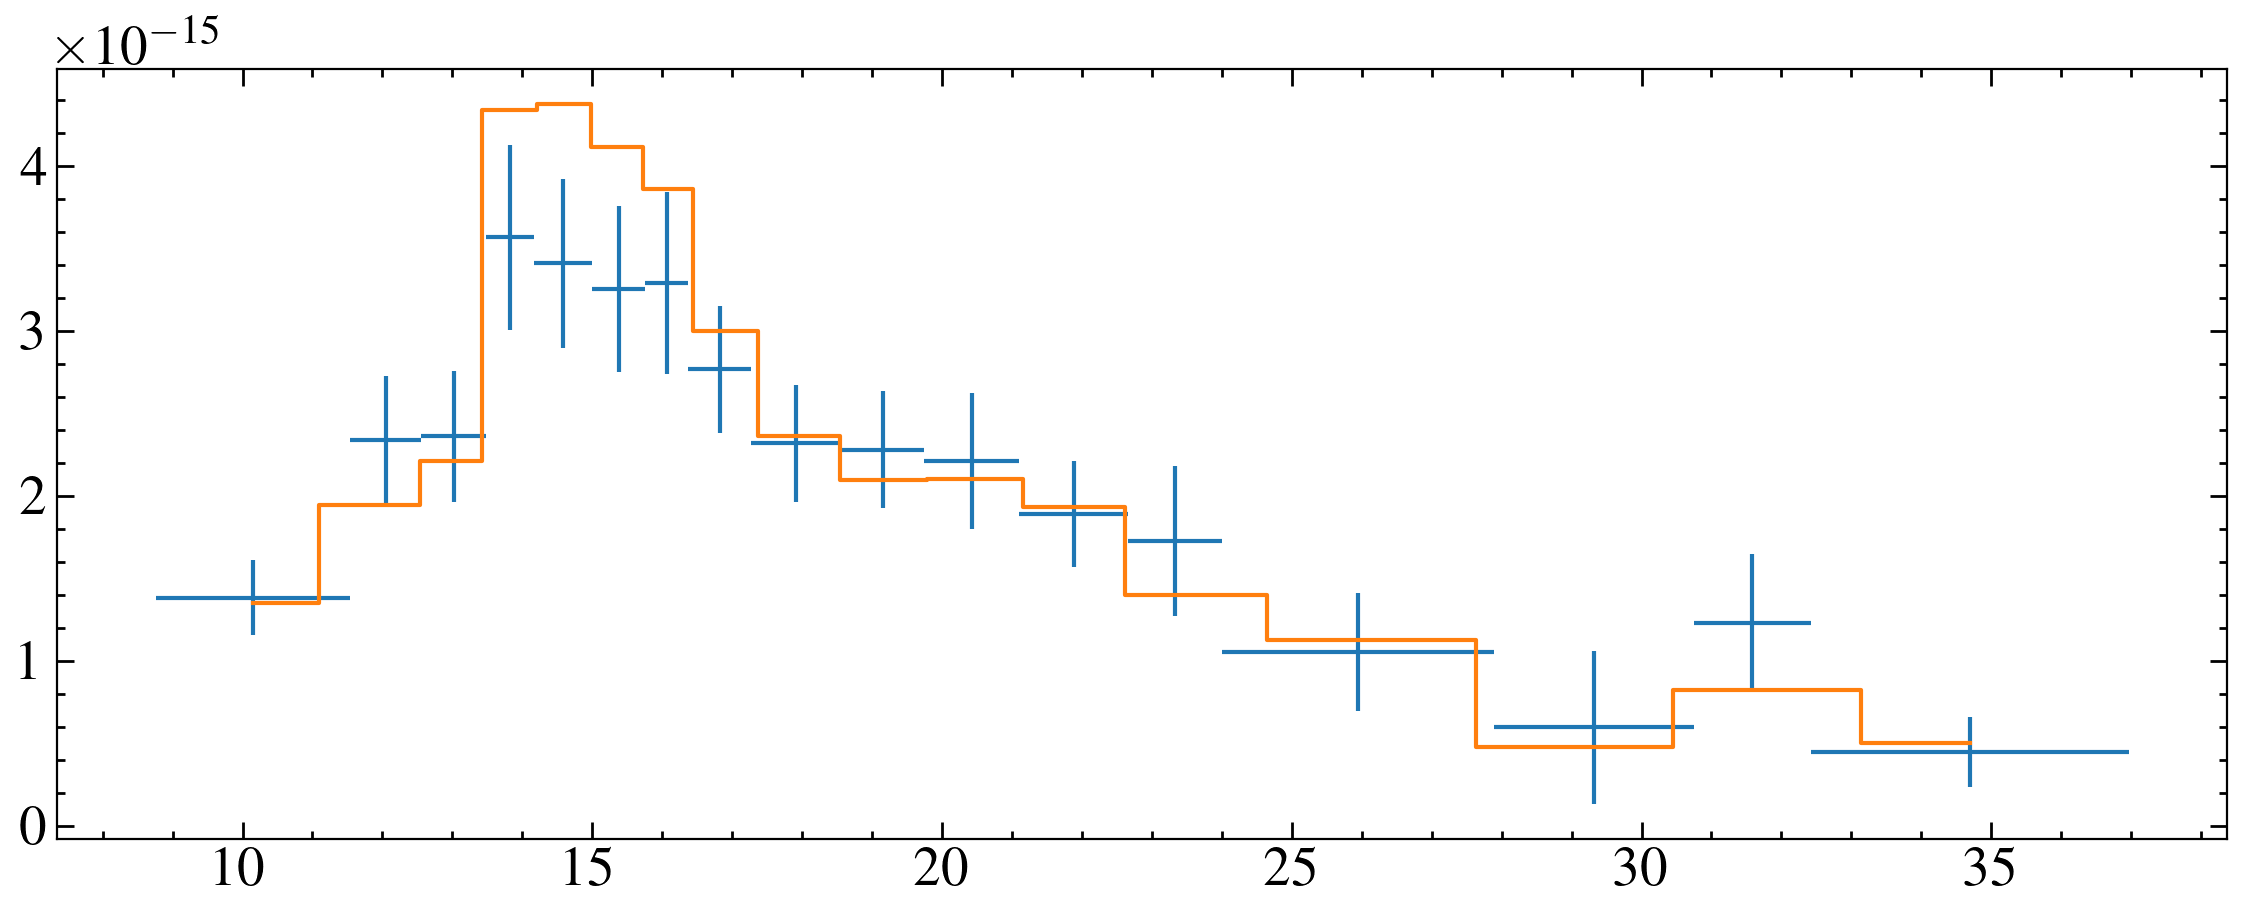

In [23]:
data = hdul[1].data
model= hdul[2].data
plt.errorbar(data['WAVE'], data['FLUX'], yerr=data['CFlux_err'], xerr=data['bin_width'], ls='none')
plt.step(data['WAVE'], data['MFlux'], where='mid')
# plt.plot(model['Wave'], model['Flux'], zorder=-1, alpha=0.7)

In [24]:
# hdr = hdul[0].header
# hdr

In [25]:
# hdr.append(('mos1_FILTER', 'Medium'))
# hdr.append(('mos2_FILTER', 'Medium'))
# hdr.append(('pn_FILTER', 'Medium'))
# hdr.append(('pn_DURATION', 13000))
# hdr.append(('pn_DATE-OBS', '2021-12-26 15:24:34'))
# hdr.append(('pn_DATE-END','2021-12-26 19:01:14' ))
# hdr.append(('OBS_ID', '0892000101'))
# hdr

In [26]:
# hdul.writeto('/media/david/2tb_ext_hd/hddata/meats/xmm/gj367/GJ367_djw.fits', overwrite=True)

In [27]:
# import prepare_xmm

# xmm_path = '/media/david/2tb_ext_hd/hddata/meats/xmm/gj367/GJ367_djw.fits'

# hlsp = dict(Table.read('meats_hlsp_info.csv'))
# # hlsp = np.genfromtxt('meats_hlsp_info.csv', delimiter=',', dtype=None, names=True)
# # xmm_path = xpath
# version = 1

# prepare_xmm.make_xmm_spectra(xmm_path, savepath, version, hlsp, apec_repo='models/', make_apec=True, save_ecsv=False, save_fits=True)

Need to do APEC errors. Waiting on Christian for parameters.

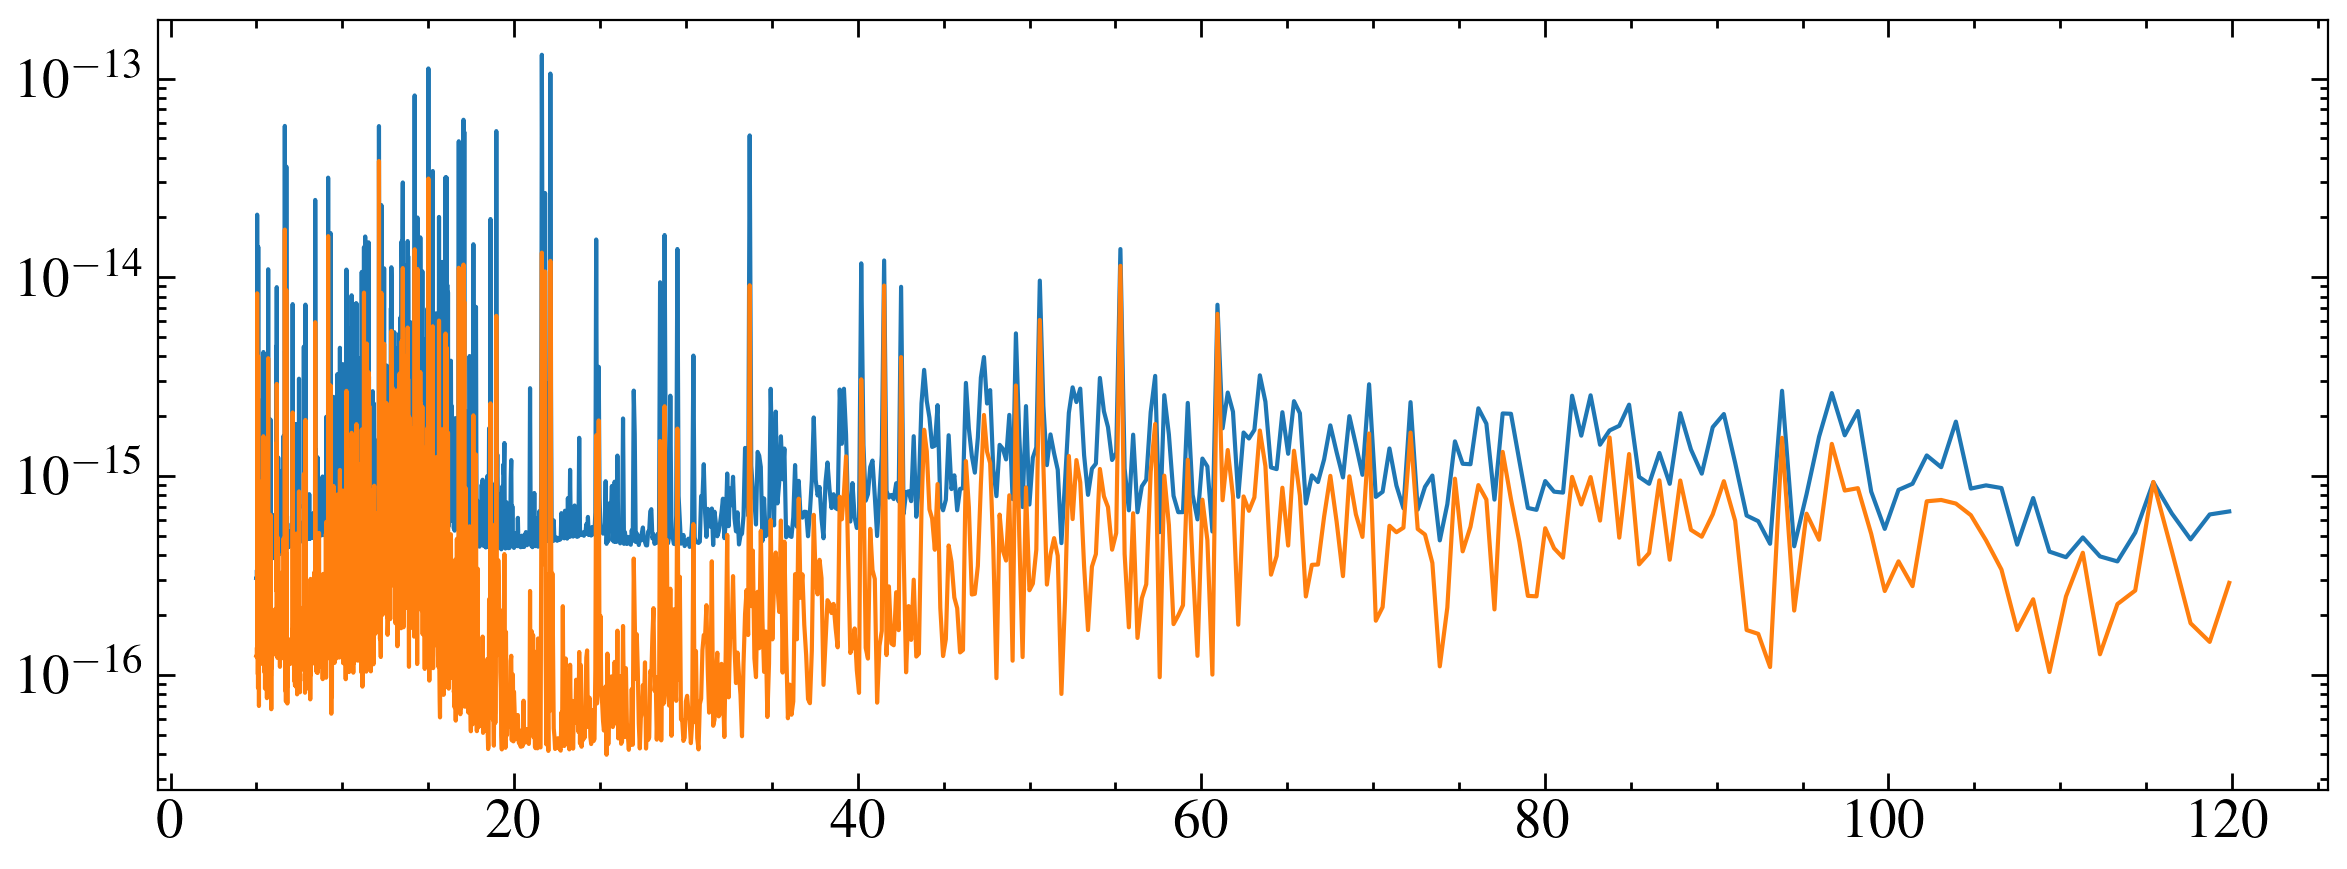

In [28]:
xray = Table.read('models/GJ367_apec_errs.ecsv')
plt.plot(xray['WAVELENGTH'], xray['FLUX'])
plt.plot(xray['WAVELENGTH'], xray['ERROR'])
plt.yscale('log')

In [29]:
import prepare_model
hdr = fits.getheader('draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)
prepare_model.make_model_spectrum('models/GJ367_apec_errs.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='apec')


Spectrum saved as hlsp_muscles_model_apec_gj_367_na_v1_component-spec.fits


In [30]:
lyapath = '/media/david/2tb_ext_hd/hddata/meats/lya/gj367/GJ367_LyA_MCMC_results.csv'
data = Table.read(lyapath)
data.dtype.names

('col0',
 'lya_model_low_2sig',
 'lya_model_low_1sig',
 'lya_model_median',
 'lya_model_high_1sig',
 'lya_model_high_2sig',
 'lya_intrinsic_low_2sig',
 'lya_intrinsic_low_1sig',
 'lya_intrinsic_median',
 'lya_intrinsic_high_1sig',
 'lya_intrinsic_high_2sig',
 'lya_ism_low_2sig',
 'lya_ism_low_1sig',
 'lya_ism_median',
 'lya_ism_high_1sig',
 'lya_ism_high_2sig',
 'lya_reversal_low_2sig',
 'lya_reversal_low_1sig',
 'lya_reversal_median',
 'lya_reversal_high_1sig',
 'lya_reversal_high_2sig',
 'lya_intrinsic_fluxes',
 'vs_n value',
 'am_n value',
 'fw_L_n value',
 'fw_G_n value',
 'h1_col value',
 'h1_b value',
 'h1_vel value',
 'h1_col2 value',
 'h1_b2 value',
 'h1_vel2 value',
 'h1_col3 value',
 'h1_b3 value',
 'h1_vel3 value',
 'd2h value',
 'p value',
 'am_b value',
 'fw_L_b value',
 'fw_G_b value',
 'wave_lya',
 'flux_lya',
 'error_lya')

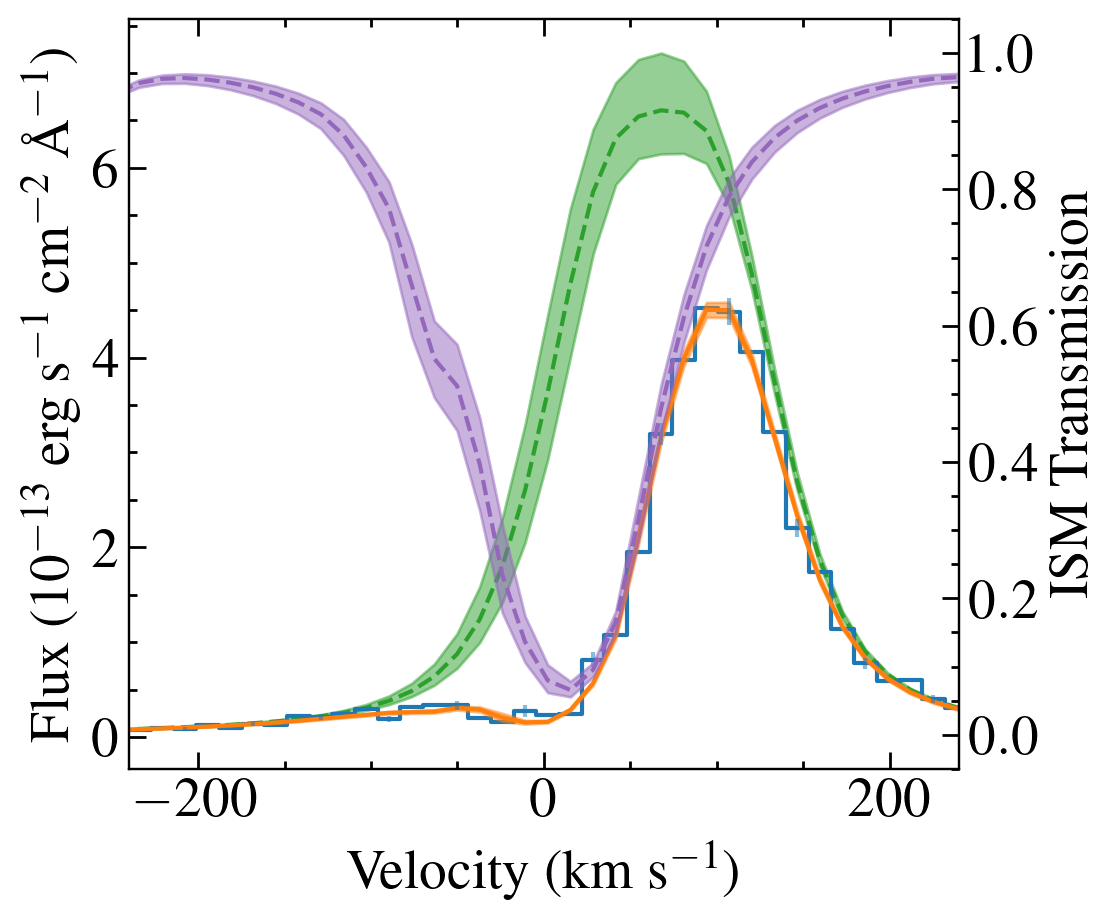

In [31]:
lya = 1215.67
ism_scale = 2.3e-13 #scaling ism to plot
fscale = 1e13 #scaling flux to axis
ism_scale *= fscale

fig, ax= plt.subplots(figsize=(6,5))
v = (data['wave_lya']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
ax.step(v, data['flux_lya']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
ax.errorbar(v, data['flux_lya']*fscale, yerr=data['error_lya']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
ax.plot(v, data['lya_model_median']*fscale, c='C1', label='Model fit', zorder=1)
ax.fill_between(v.value, data['lya_model_high_1sig']*fscale,data['lya_model_low_1sig']*fscale, color='C1', alpha=0.5)

ax.plot(v, data['lya_intrinsic_median']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
ax.fill_between(v.value, data['lya_intrinsic_high_1sig']*fscale,data['lya_intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)

# name = os.path.split(spec)[1][:-34]
# ax.set_title(name, size=20)

# xlim = min([abs(min(v.value)), max(v.value)])-10
xlim = 240
ax.set_xlim(-xlim, xlim)
ax2=ax.twinx()
ax2.plot(v, data['lya_ism_median'], c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
ax2.fill_between(v.value, data['lya_ism_high_1sig'],data['lya_ism_low_1sig'], color='C4', alpha=0.5, zorder=-10)
ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel('ISM Transmission')


ax.set_xlabel('Velocity (km s$^{-1}$)', size=20)
ax.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)

fig.tight_layout()

# fig.savefig('plots/toi-776_lya.pdf')

In [32]:



lw, lf, le = data['wave_lya'], data['lya_intrinsic_median'], np.mean([data['lya_intrinsic_high_1sig']-data['lya_intrinsic_median'], data['lya_intrinsic_median']-data['lya_intrinsic_low_1sig']], axis=0)
lyatab = Table([lw, lf, le], names=['WAVELENGTH', 'FLUX', 'ERROR'])
lyatab.write('models/gj367_lya.ecsv', overwrite=True)

prepare_model.make_model_spectrum('models/gj367_lya.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='lya')



Spectrum saved as hlsp_muscles_model_lya_gj_367_na_v1_component-spec.fits


In [33]:
#PHX
prepare_model.make_model_spectrum('models/GJ_367_phoenix_interpolated.ecsv', 1, sed_data,
                                  savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')

Spectrum saved as hlsp_muscles_model_phx_gj_367_na_v1_component-spec.fits


In [34]:
data['h1_col value']

17.60108628288116
17.695448627369274
17.781959684907306
17.869896076344432
17.963792624677694
--
--
--
--
...
--


In [37]:
# fig, ax = plt.subplots()
hlsps = glob.glob('draft_hlsp/gj_367/*.fits')
# for spec in hlsps:
#     data = fits.getdata(spec, 1)
#     if 'phx' in spec:
#         norm = fits.getheader(spec, 0)['NORMFAC']
#         ax.plot(data['WAVELENGTH'], data['FLUX']*norm, alpha=0.5)
#     else:
#         ax.plot(data['WAVELENGTH'], data['FLUX'], alpha=0.5)
    
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(9, 100000)
# ax.set_ylim(1e-17, 1e-11)

Oh no there's a gap.

2889.8137795894413 5698.308868665037
1194.3834974320055 1248.753833977949
1065.0 1366.9913
1574.1781519961073 3158.1913940611666


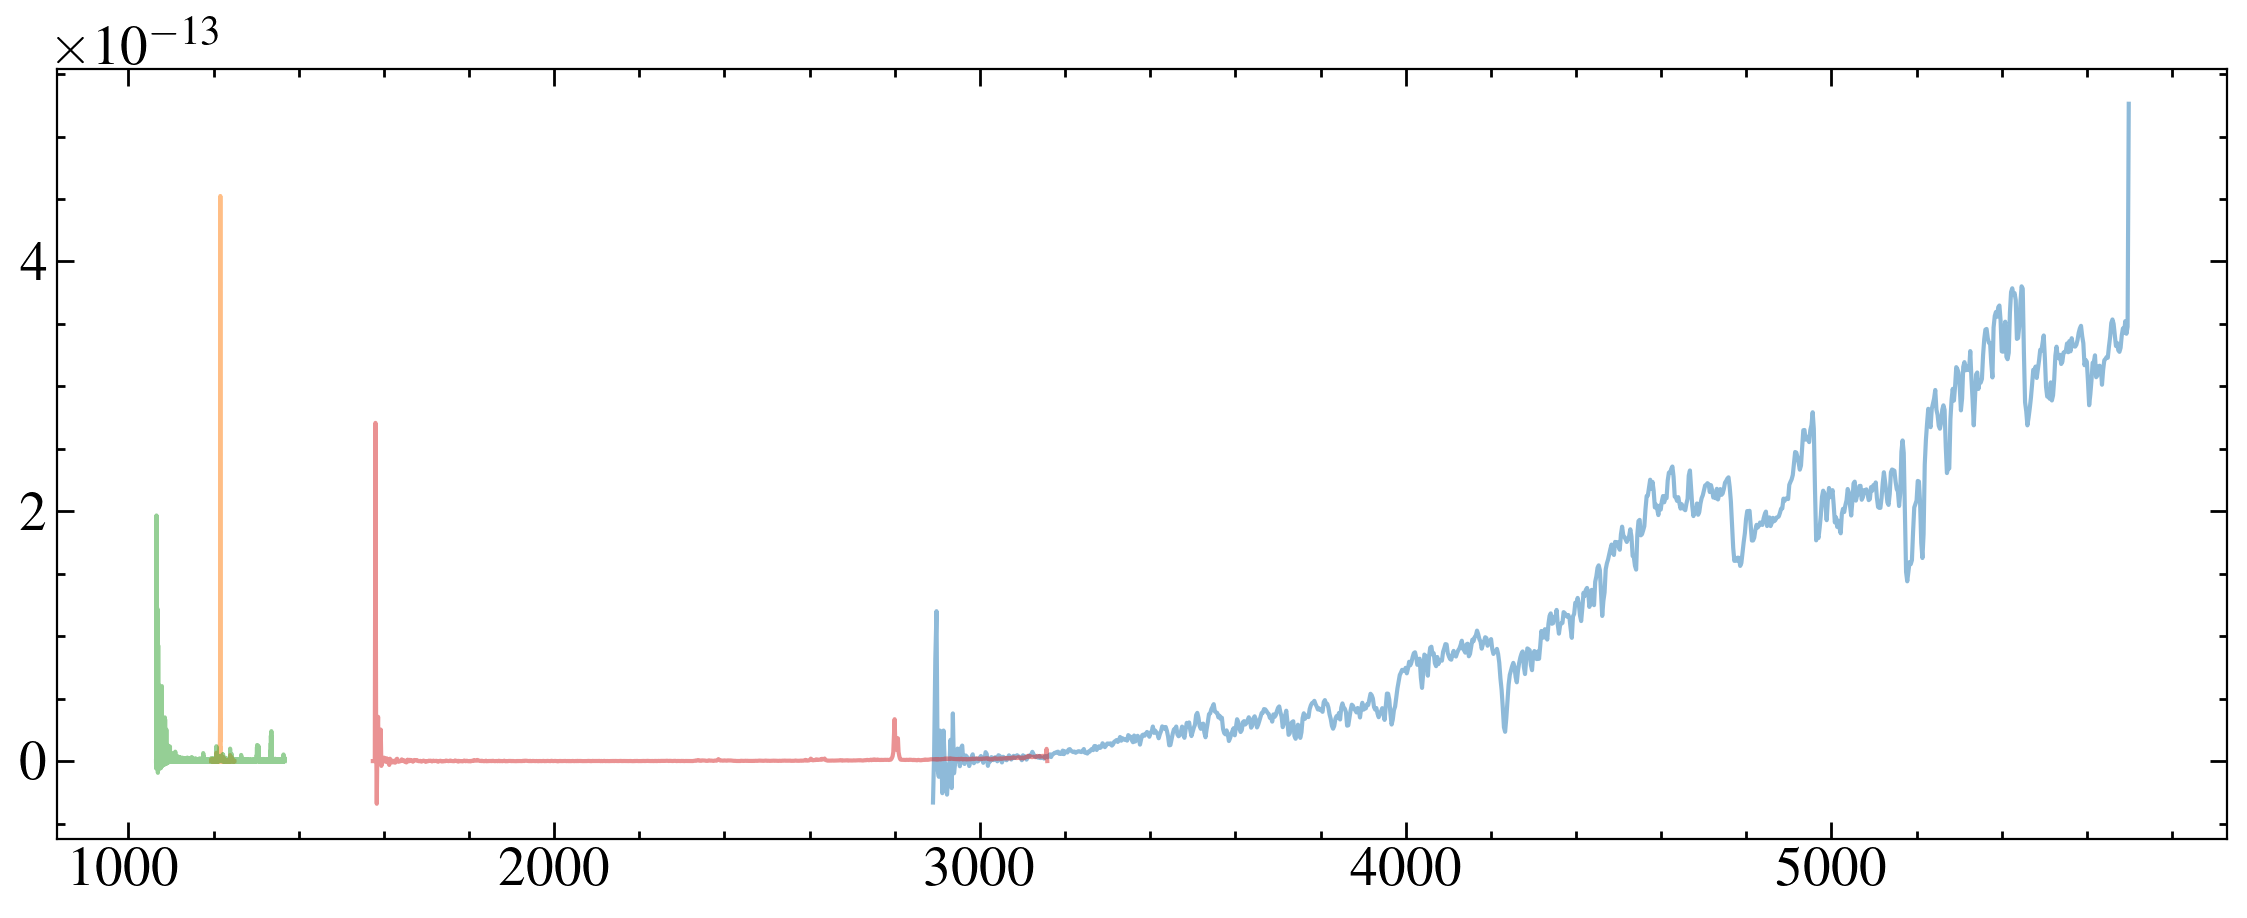

In [38]:
fig, ax = plt.subplots()
for spec in hlsps:
    data = fits.getdata(spec, 1)
    if 'hst' in spec:
        ax.plot(data['WAVELENGTH'], data['FLUX'], alpha=0.5)
        print(data['WAVELENGTH'][0], data['WAVELENGTH'][-1])
    
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(9, 100000)
# ax.set_ylim(1e-17, 1e-11)

In [39]:
hlsps

['draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g430l_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_model_lya_gj_367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_multi_multi_gj_367_broadband_v1_const-res-sed.fits',
 'draft_hlsp/gj_367/hlsp_muscles_multi_multi_gj_367_broadband_v1_var-res-sed.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_cos_gj_367_g130m_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_model_apec_gj_367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_model_phx_gj_367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_model_dem_gj_367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g230l_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_multi_multi_gj_367_broadband_v1_adapt-const-res-sed.fits',
 'draft_hlsp/gj_367/hlsp_muscles_xmm_epic_gj367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscl

In [40]:
# for spec in [hlsps[3], hlsps[5]]:
#     data = fits.getdata(spec, 1)
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if 'g130m' in spec:
#         mask = w > 1000
#     if 'g230l' in spec:
#         mask = w > 1600
    
#     w, f, e = w[mask], f[mask], e[mask]
    
#     plt.step(w, f, where='mid', c='C0')
#     plt.step(w, e, where='mid', c='C1', alpha=0.5)
#     print(w[0], w[-1])
    
# plt.yscale('log')
# plt.ylim(1e-17)
# plt.xlim(1000, 2250)

Find a similar M dwarf? GJ 832?

In [41]:
# mmpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/gj832/hlsp_muscles_multi_multi_gj832_broadband_v22_var-res-sed.fits'
# mmpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/gj667c/hlsp_muscles_multi_multi_gj667c_broadband_v22_var-res-sed.fits'
mmpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_multi_multi_gj674_broadband_v24_var-res-sed.fits'
mmdata = fits.getdata(mmpath, 1)
mmw, mmf, mme= mmdata['WAVELENGTH'], mmdata['FLUX'], mmdata['ERROR']


In [42]:
1000/219.64625138839503

4.552775172255158

9.42


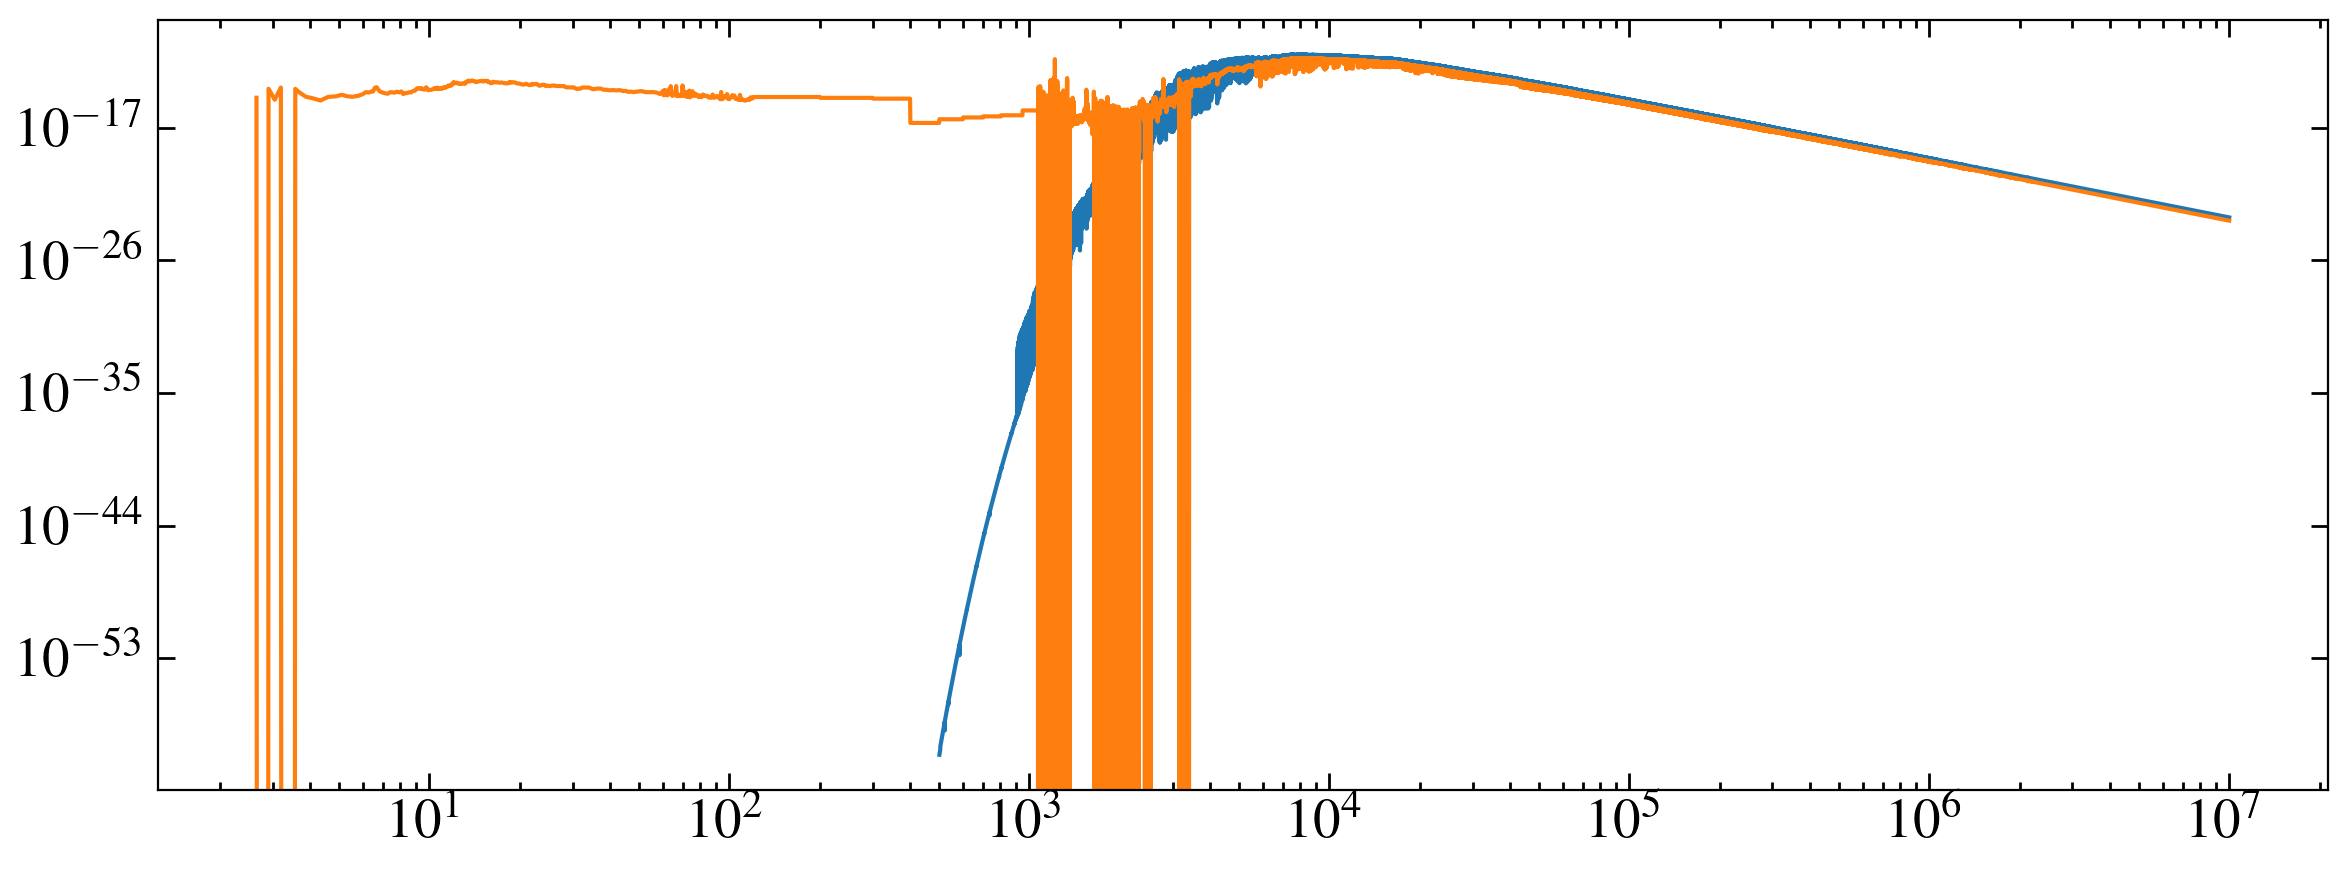

In [43]:
d_gj674 = 4.552775
# d_gj667c = 7.242897071914
scale = (d_gj674/distance)**2
# scale = (d_gj667c/distance)**2

plt.plot(pw, pf*normfac)
plt.plot(mmw, mmf*scale)

plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-17)

print(distance)

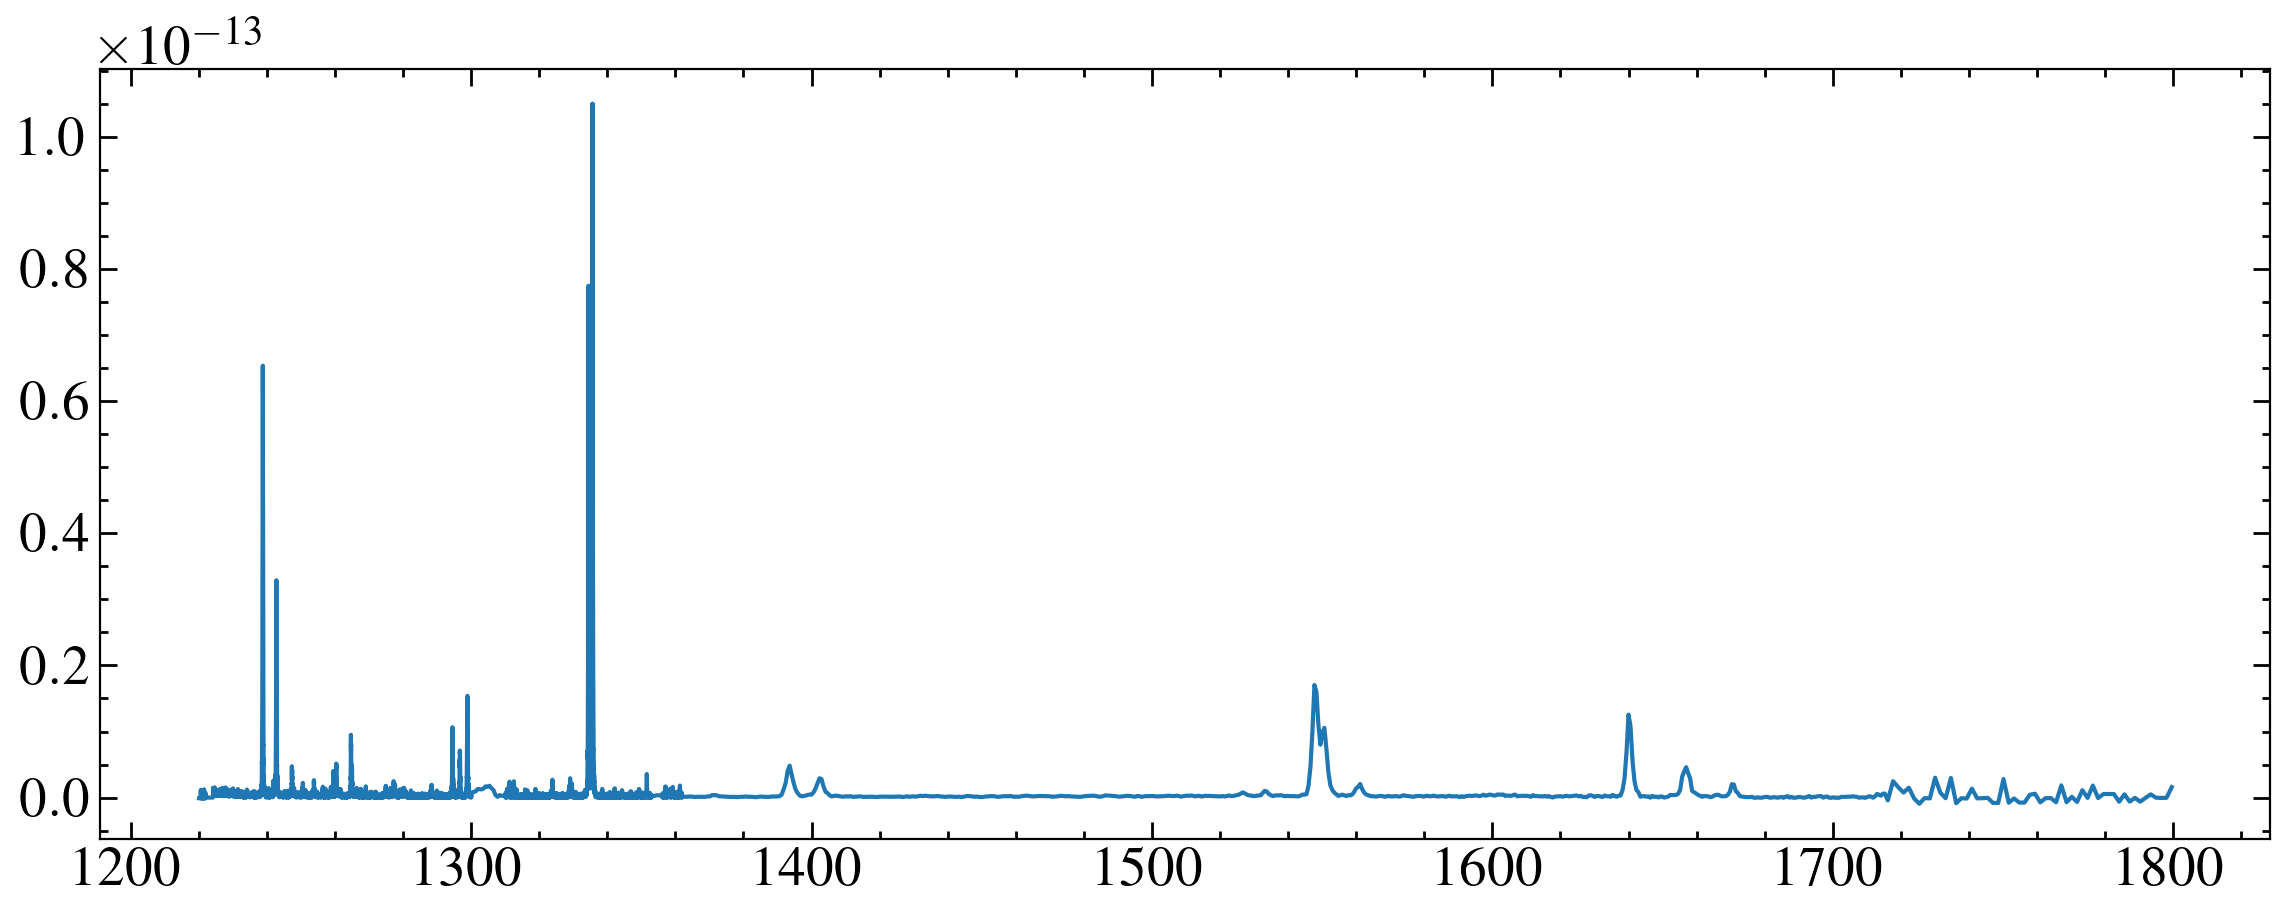

In [44]:
mask = (mmw > 1220) & (mmw < 1800)
mmw, mmf, mme = mmw[mask], mmf[mask], mme[mask]
plt.plot(mmw, mmf)

(1250.0, 1400.0)

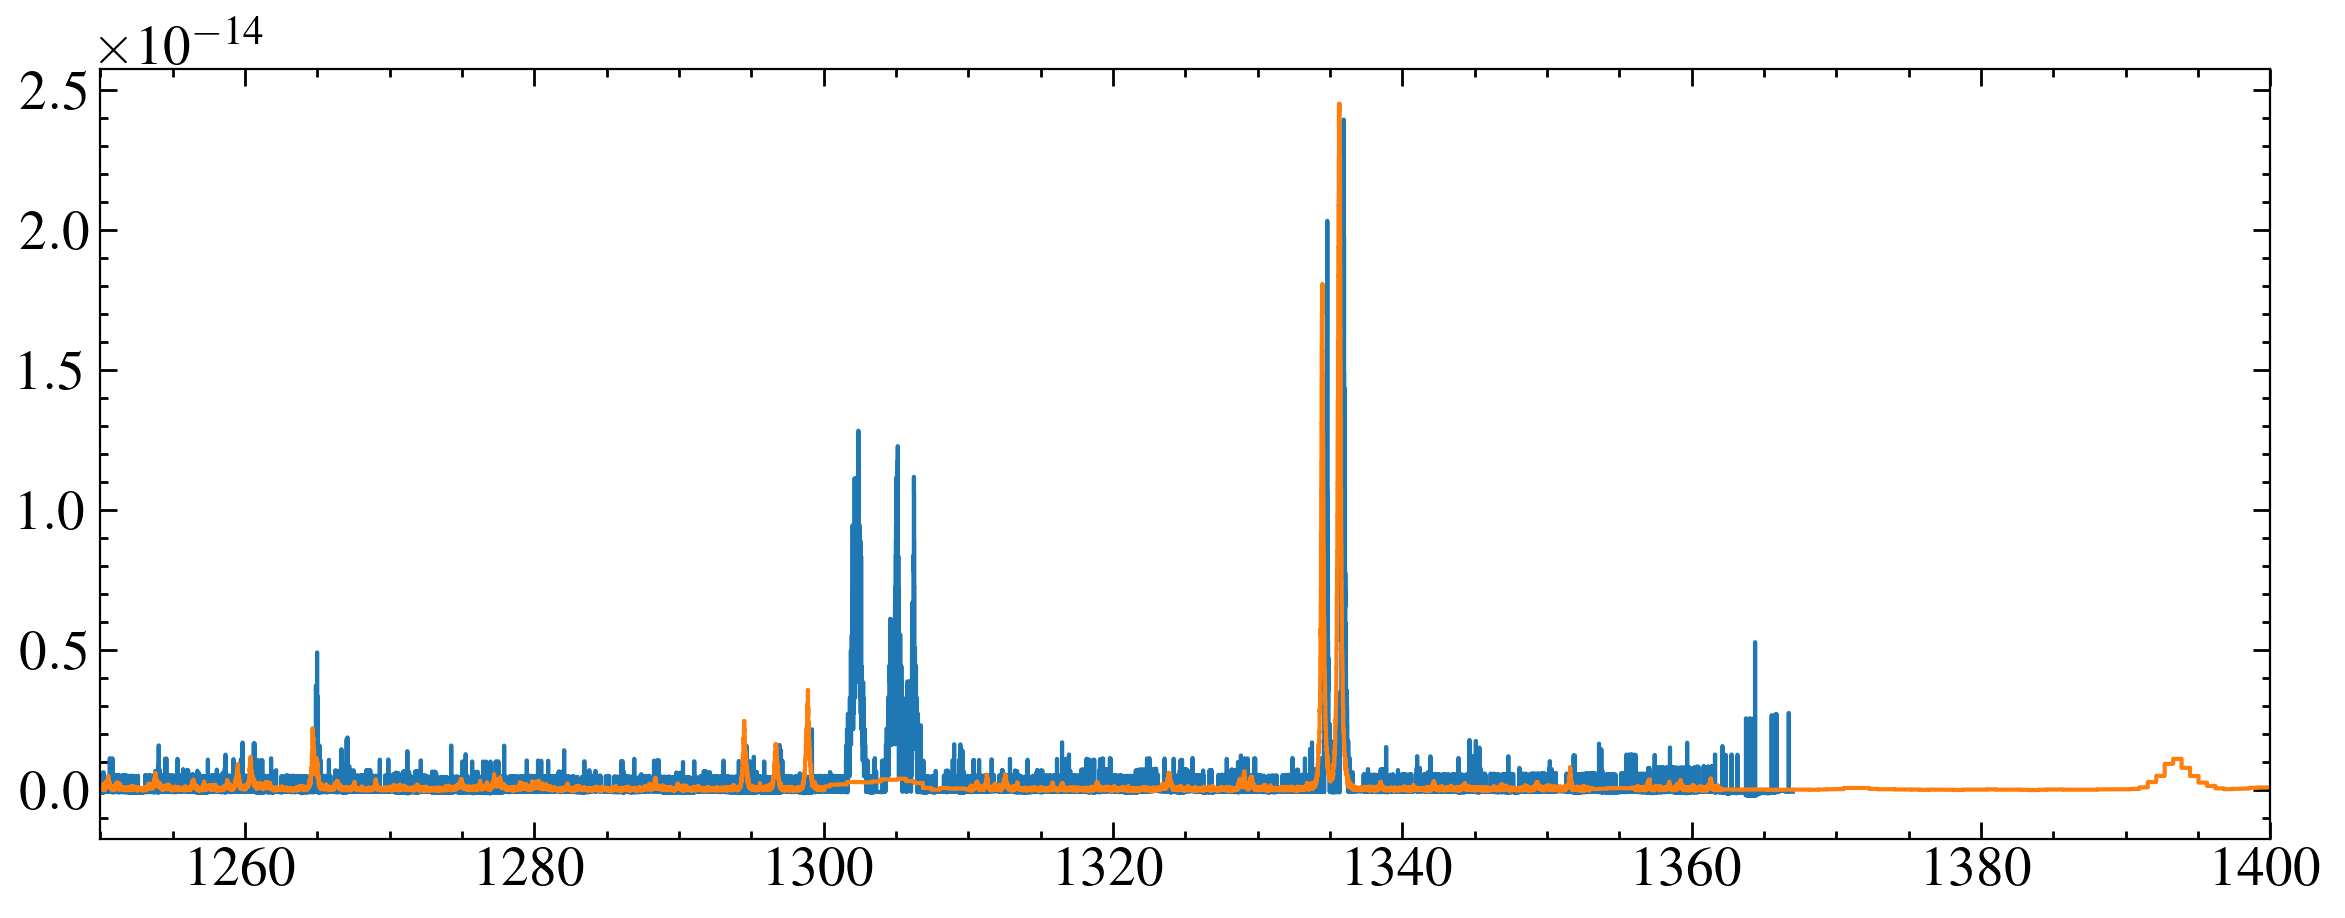

In [45]:
#compare emission lines
# scale = (d_gj832/distance)**2
data = fits.getdata(hlsps[5], 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1100

w, f, e = w[mask], f[mask], e[mask]
    

plt.step(w, f, where='mid')


plt.step(mmw, mmf*scale, where='mid')

plt.xlim(1250, 1400)

Comparing in and out of flare spectra.

In [46]:
flarespecs = glob.glob('/media/david/2tb_ext_hd/hddata/mega_muscles/gj674_flare/*txt')
flarespecs

['/media/david/2tb_ext_hd/hddata/mega_muscles/gj674_flare/GJ674_mega_G130M_Flare.sav.txt',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/gj674_flare/GJ674_mega_G130M_Quiesc.sav.txt']

(1310.0, 1360.0)

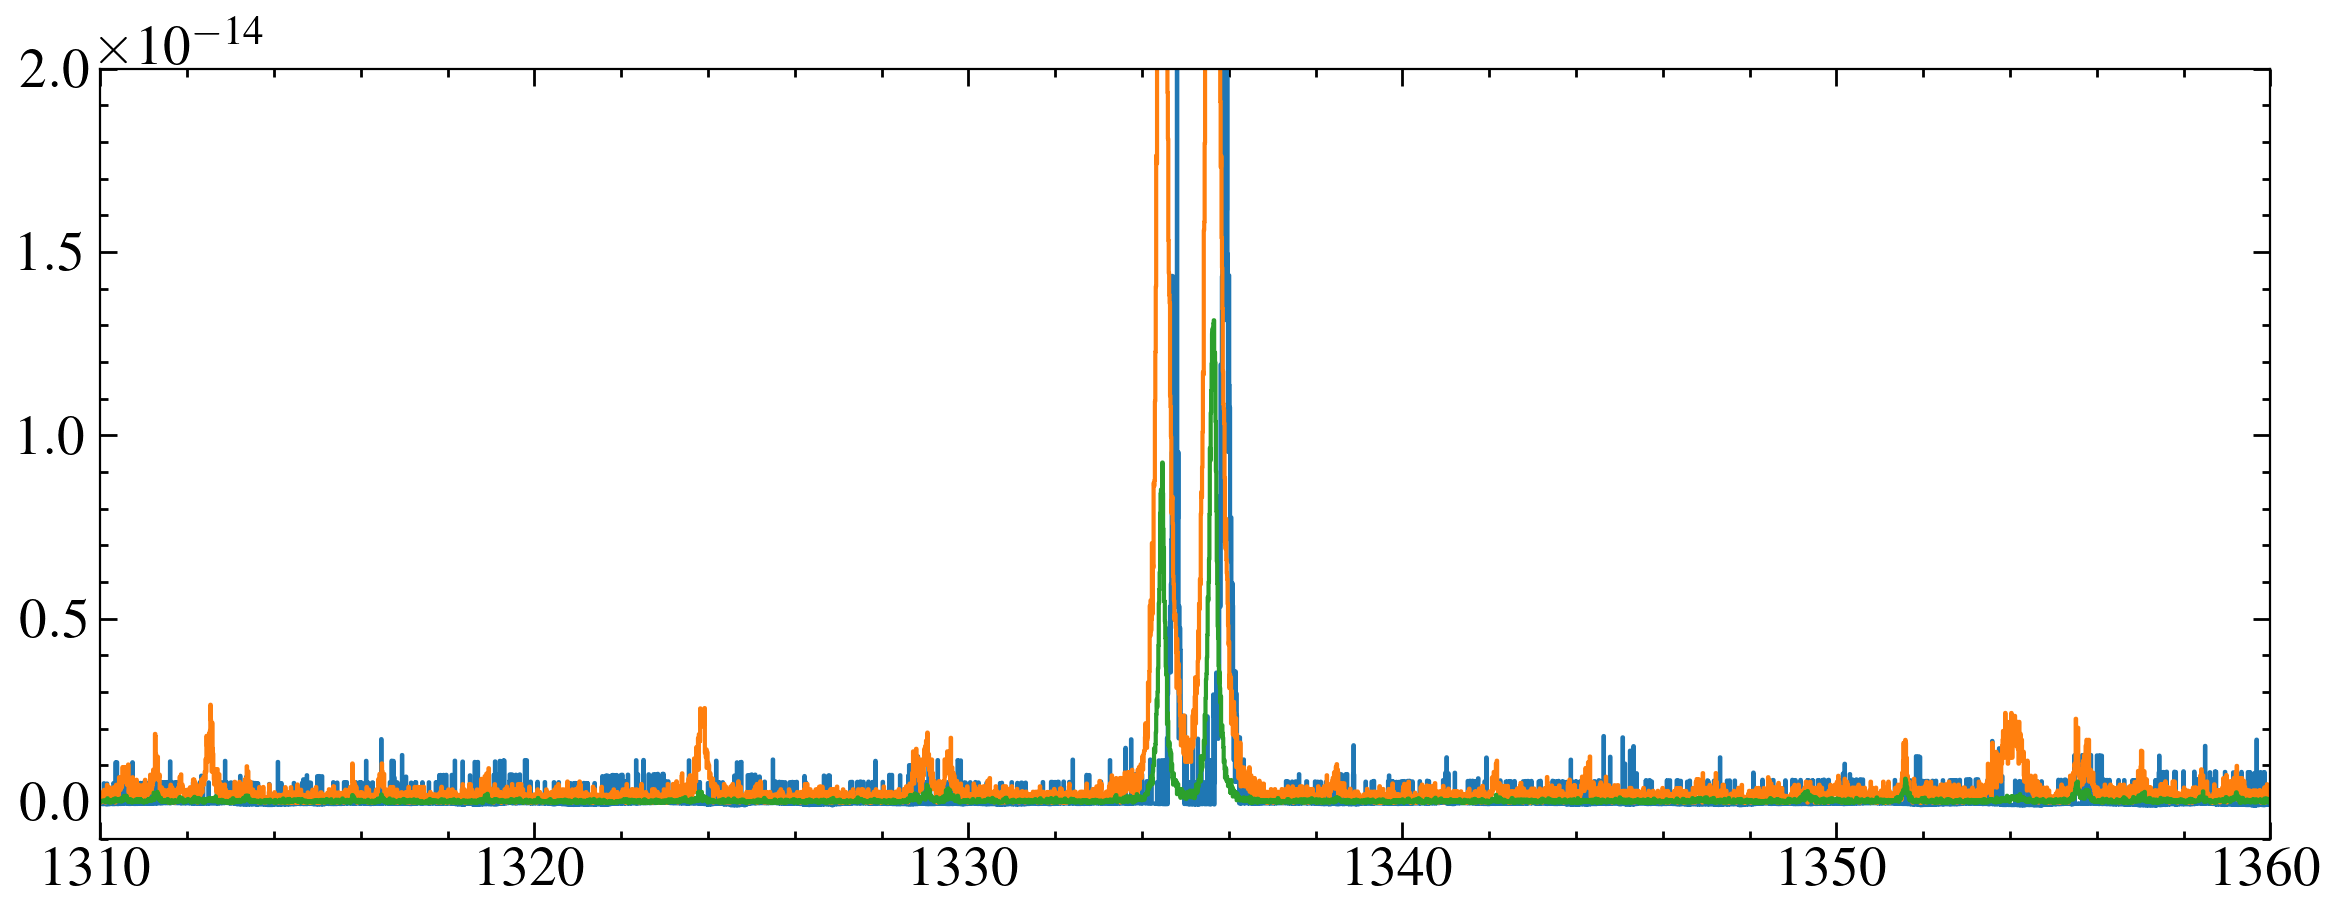

In [58]:
data = fits.getdata(hlsps[5], 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1100

w, f, e = w[mask], f[mask], e[mask]

plt.step(w, f, where='mid')



for spec in flarespecs:
    gw, gf, ge = np.loadtxt(spec, unpack=True, skiprows=1)
    
    plt.step(gw, gf*scale, where='mid')
    
plt.ylim(-0.1e-14, 2e-14)
plt.xlim(1310, 1360)

The infil region is STIS???? Why is there a contiunumm? Moving this to bottom of notebook

In [59]:
 # Nh = 1e18 cm-2 (fixed)
 #  log (Flux /erg/cm2/s) (0.2-10.0 keV): -12.97 (-0.15, +0.12)
 #  kT1 = 1.39 (-0.29, +1.00) MK
 #  kT2 = 7.73 (-1.53, +0.83) MK
 #  EM1 = 9.7 (-5.1, +11.8) x 1e49 cm-3
 #  EM2 = 2.6 (-0.3, +0.4) x 1e49 cm-3

# (7.73*u.MK).to(u.keV, equivalencies=u.temperature_energy())
# 16312


GJ 674 looks great.

In [60]:
data.names

['WAVELENGTH',
 'WAVELENGTH0',
 'WAVELENGTH1',
 'FLUX',
 'ERROR',
 'EXPTIME',
 'DQ',
 'EXPSTART',
 'EXPEND']

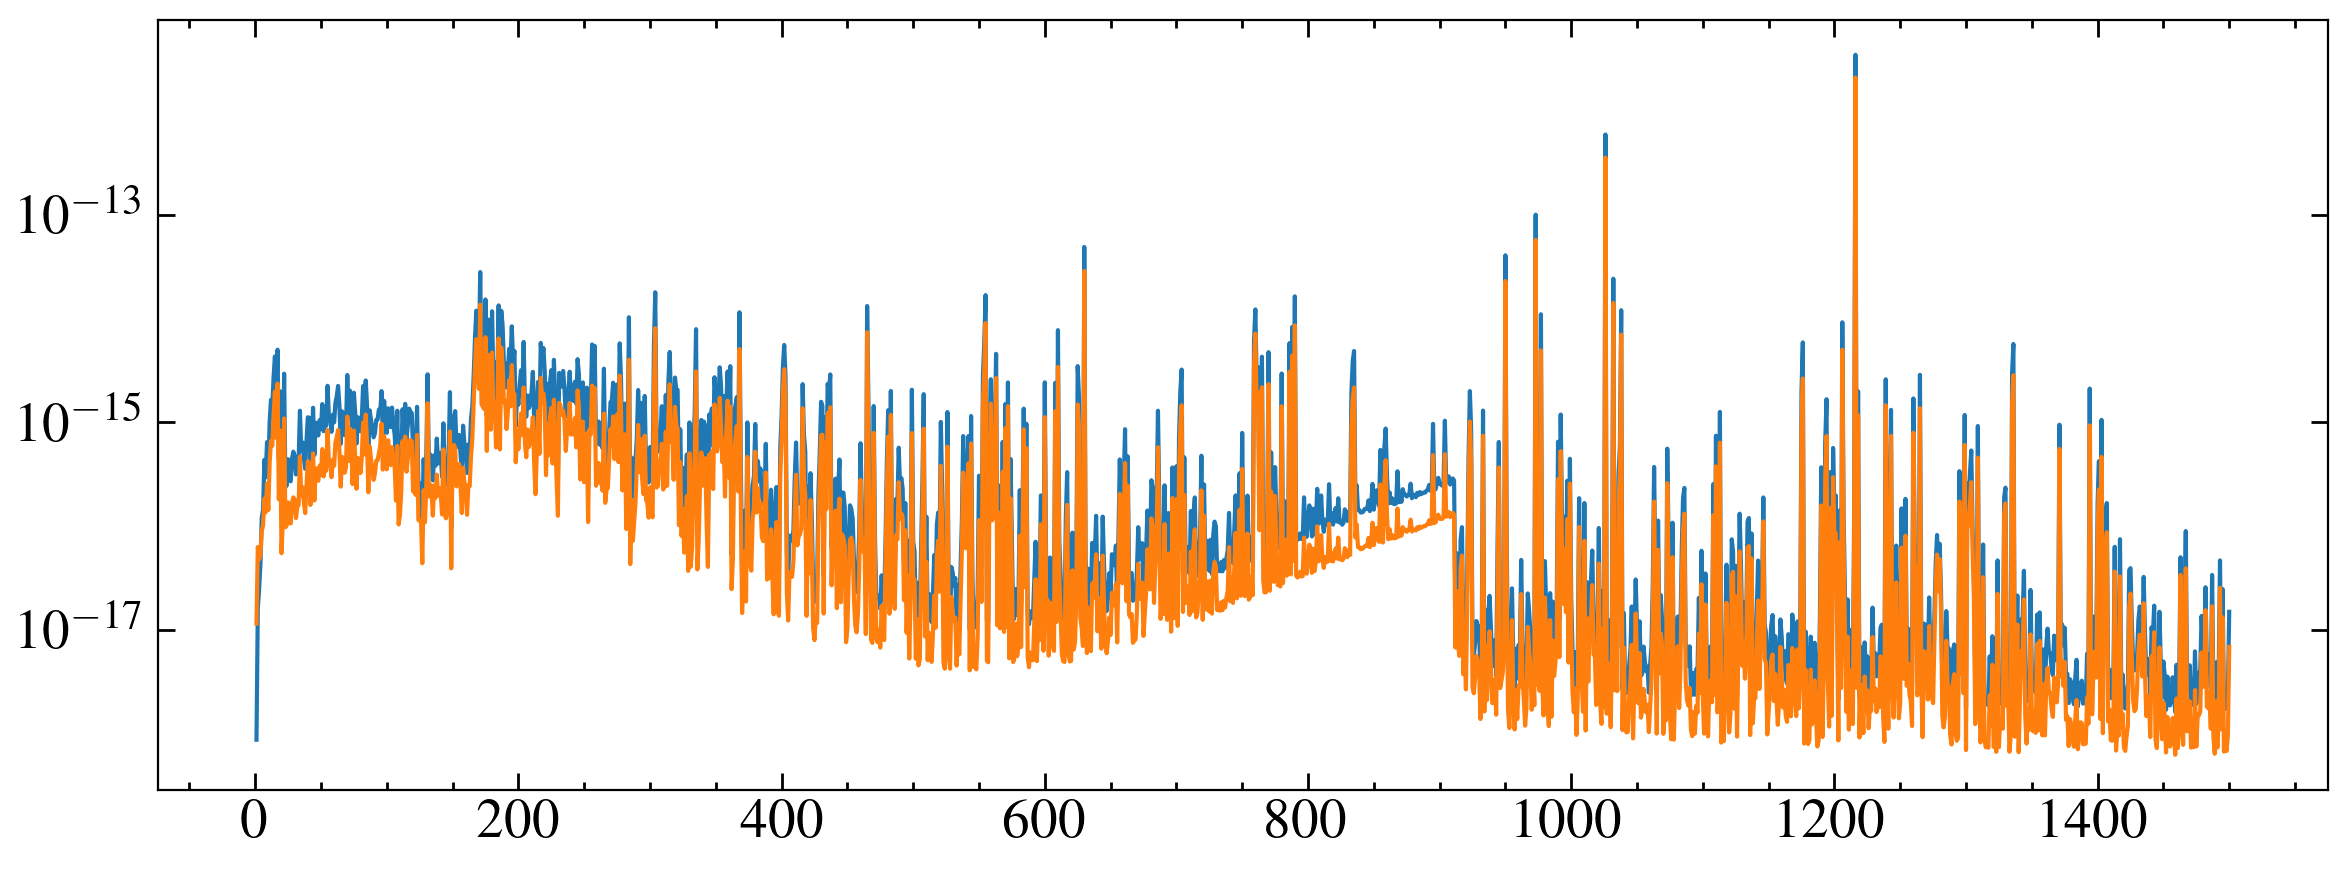

In [61]:
#dem 
dempath = '/media/david/2tb_ext_hd/hddata/meats/dems/gj367/spectrum_gj_367_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
demtab.write('models/gj367_dem.ecsv', overwrite=True)



In [62]:
#dem
prepare_model.make_model_spectrum('models/gj367_dem.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='dem')

Spectrum saved as hlsp_muscles_model_dem_gj_367_na_v1_component-spec.fits


(1e-17, 1e-11)

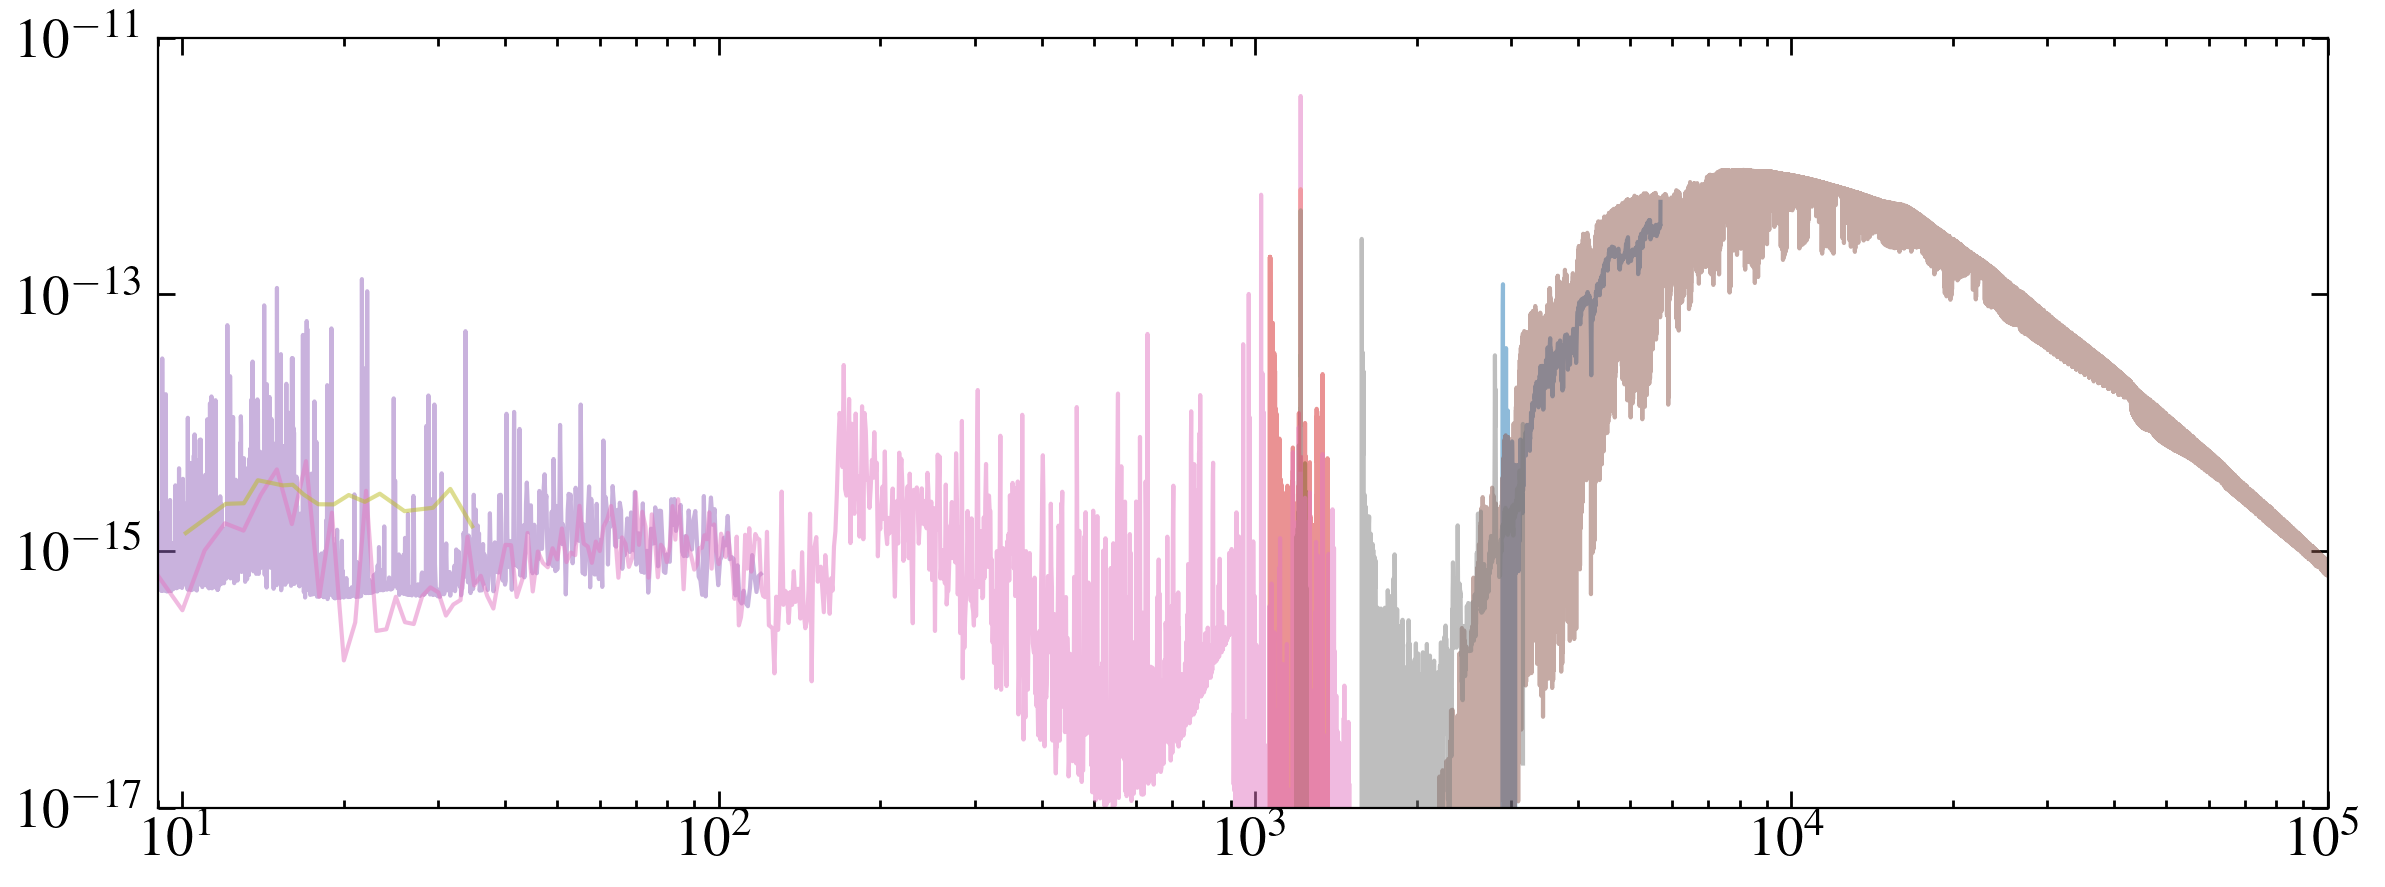

In [63]:
fig, ax = plt.subplots()
hlsps = glob.glob('draft_hlsp/gj_367/*.fits')
for spec in hlsps:
    if 'multi' not in spec:
        data = fits.getdata(spec, 1)
        if 'phx' in spec:
            norm = fits.getheader(spec, 0)['NORMFAC']
            ax.plot(data['WAVELENGTH'], data['FLUX']*norm, alpha=0.5)
        else:
            ax.plot(data['WAVELENGTH'], data['FLUX'], alpha=0.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(9, 100000)
ax.set_ylim(1e-17, 1e-11)

Are the STIS data for GJ674 weird?

1715.7670136535671


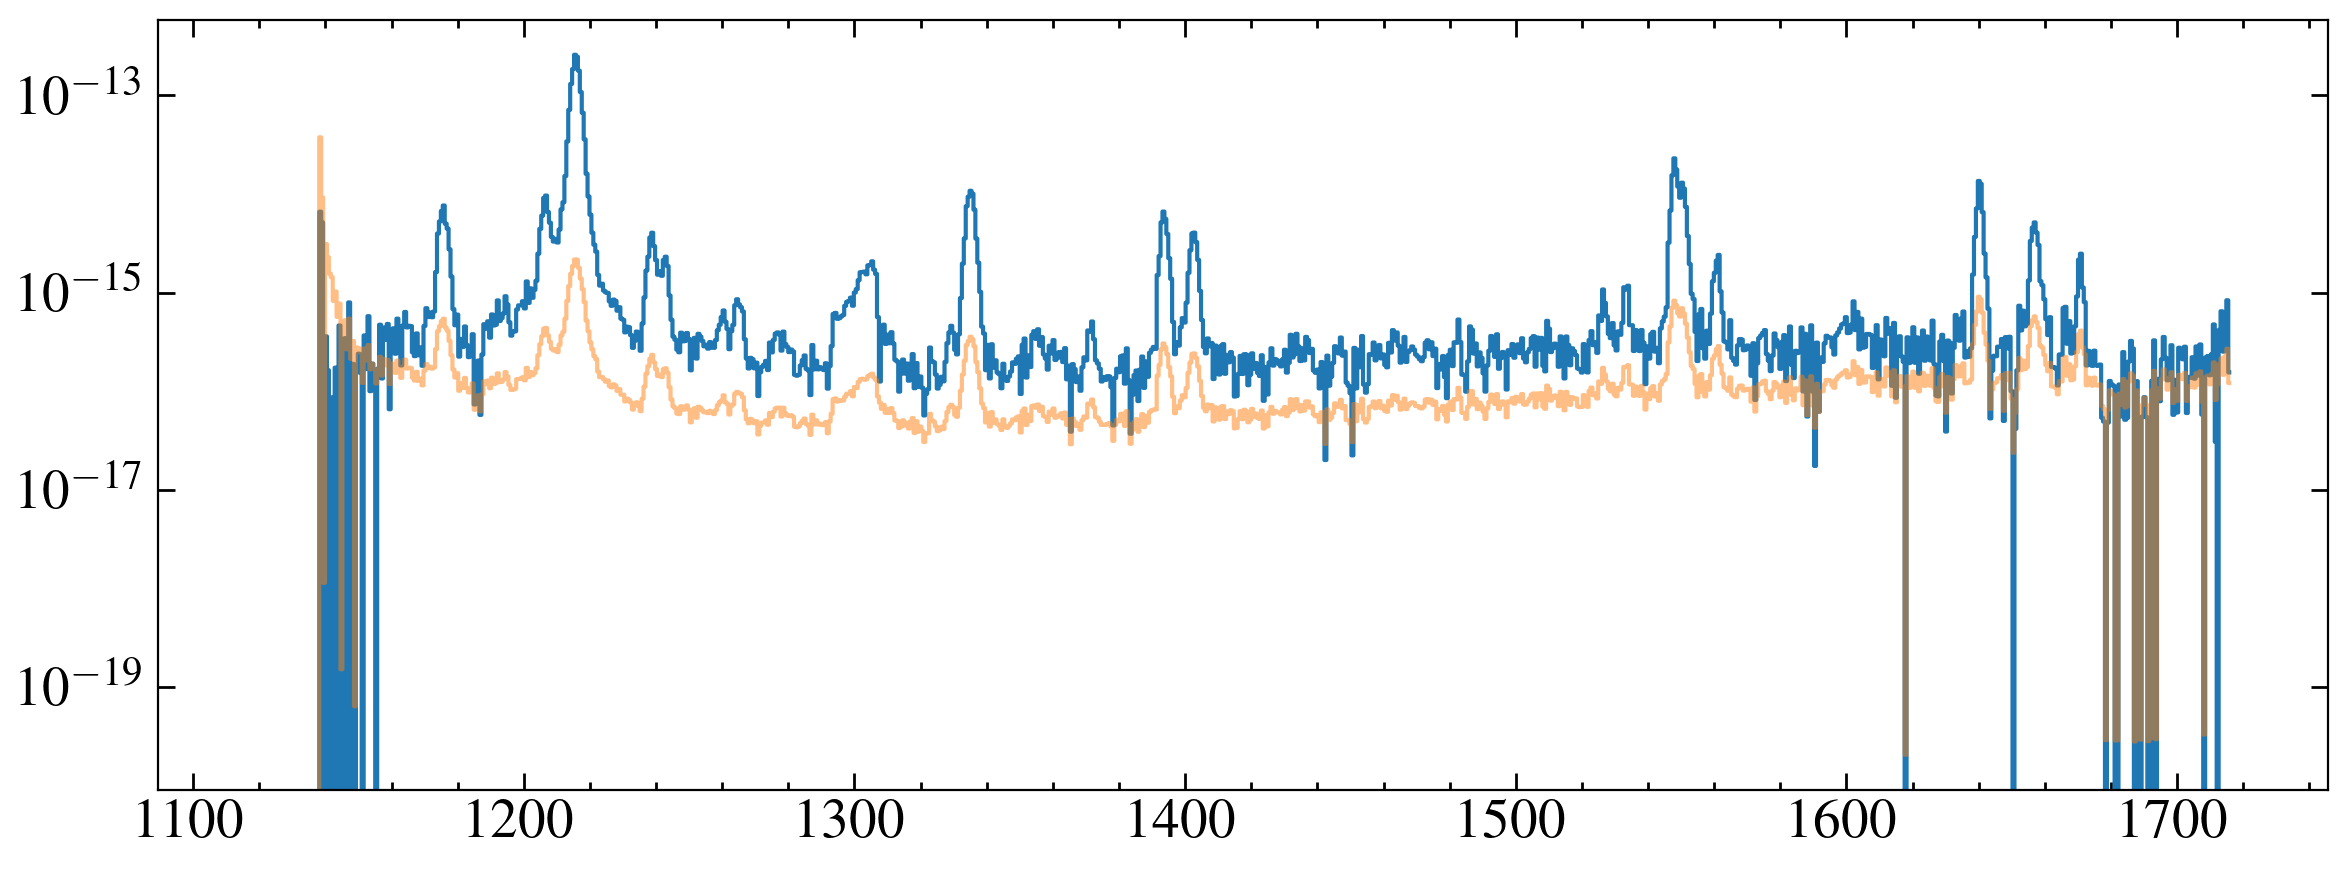

1715.735427461613


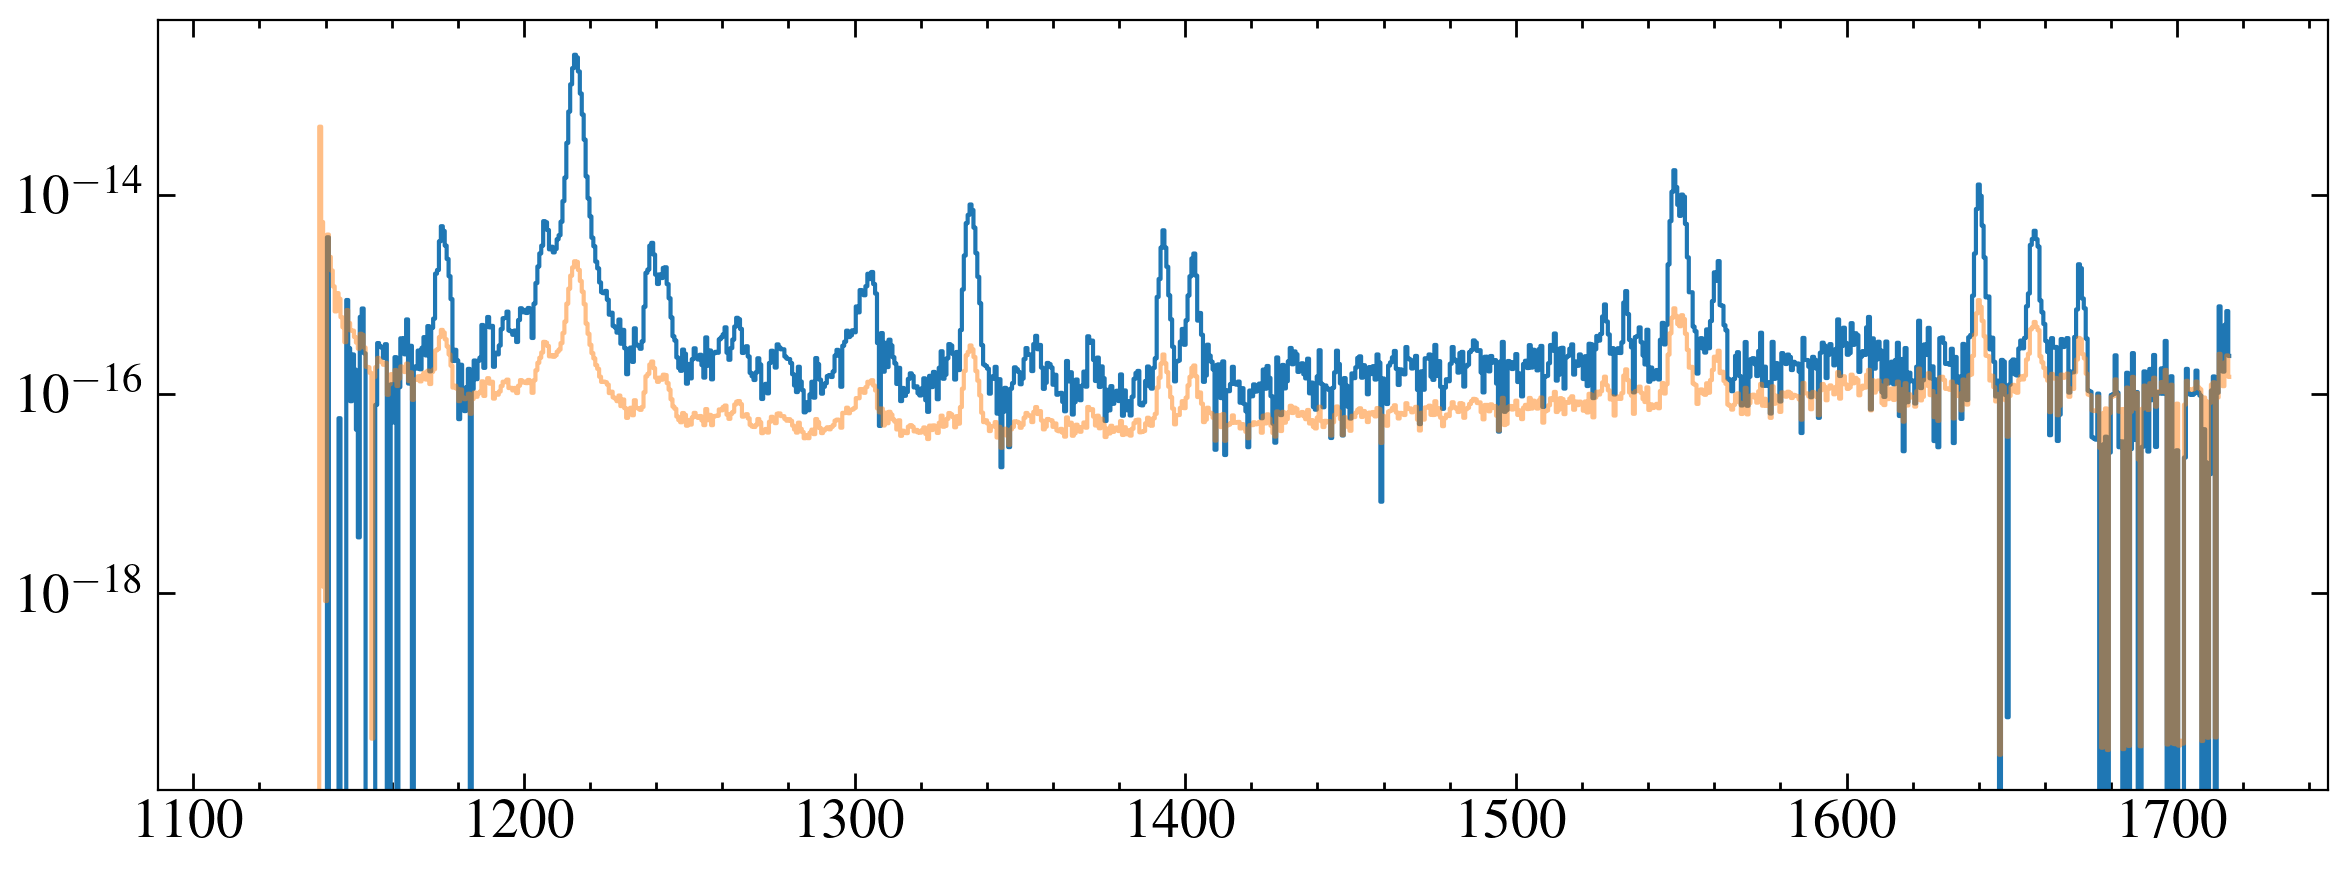

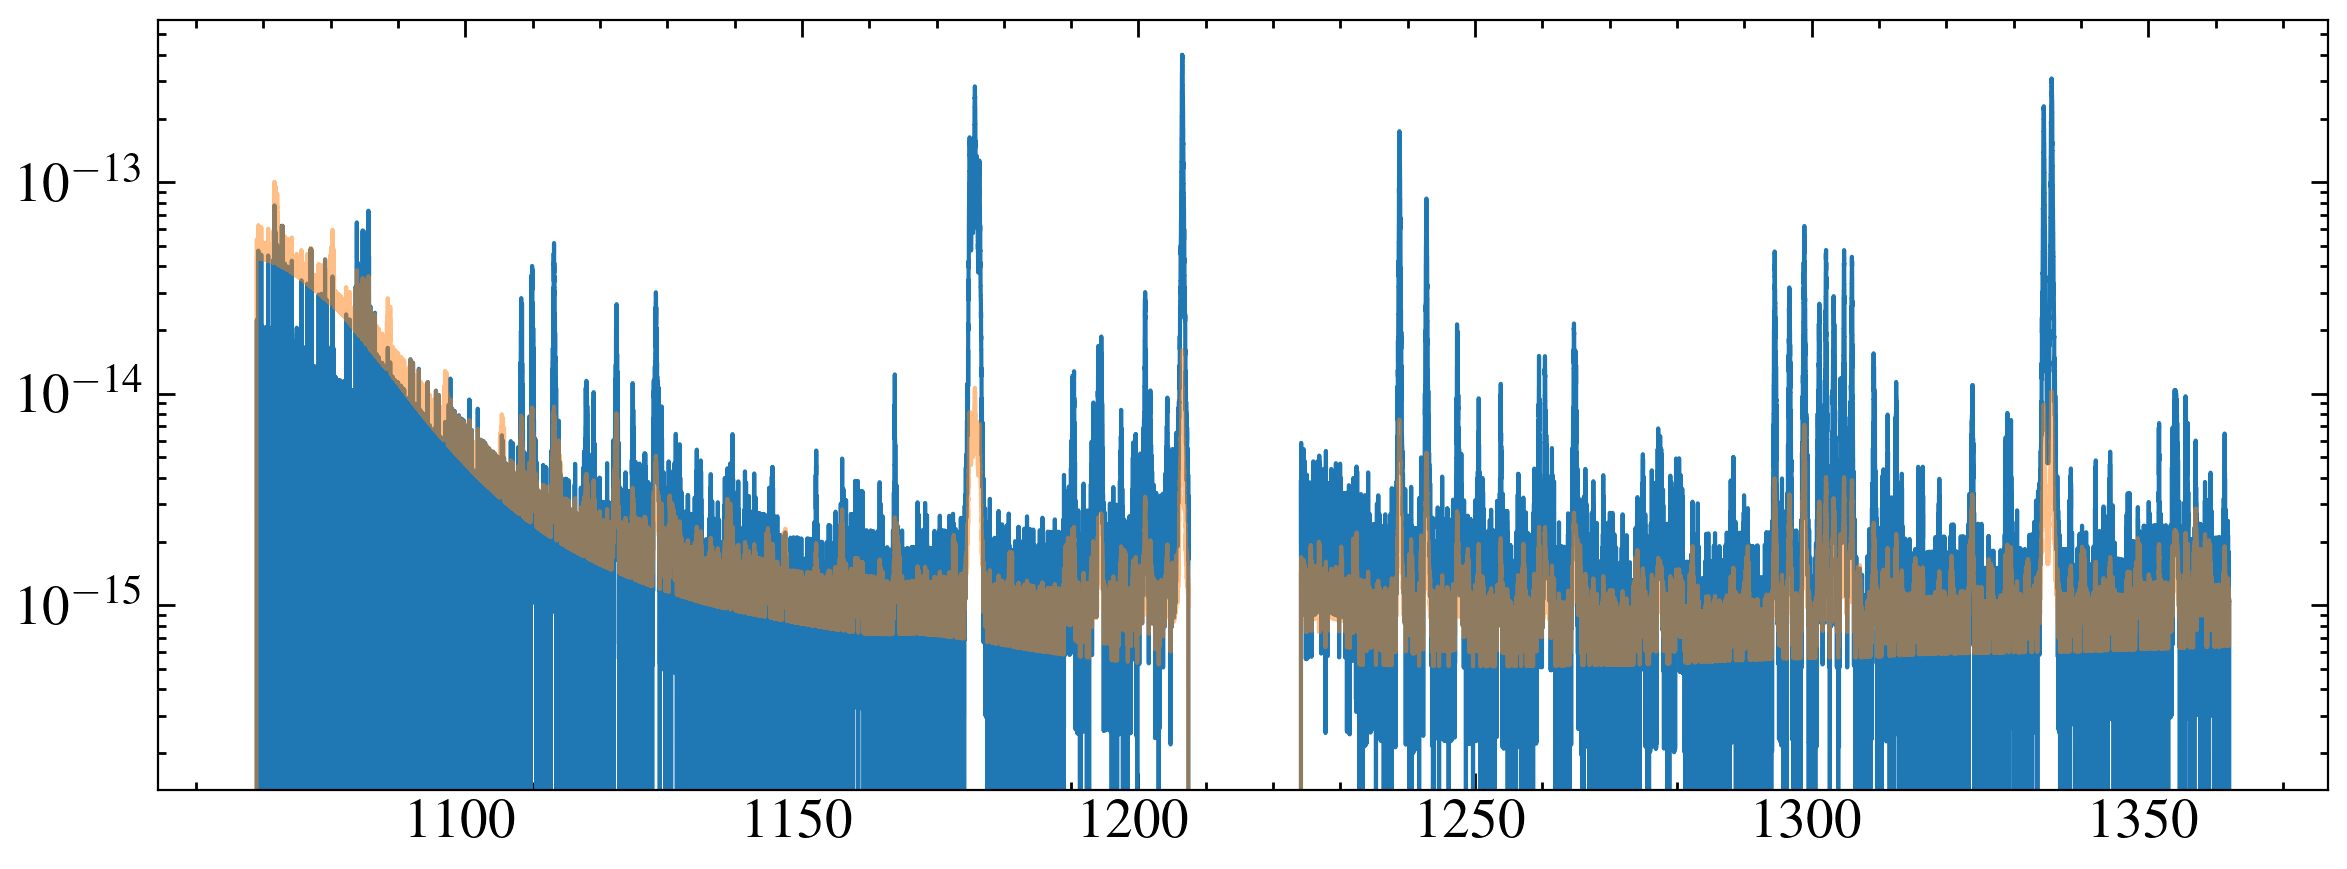

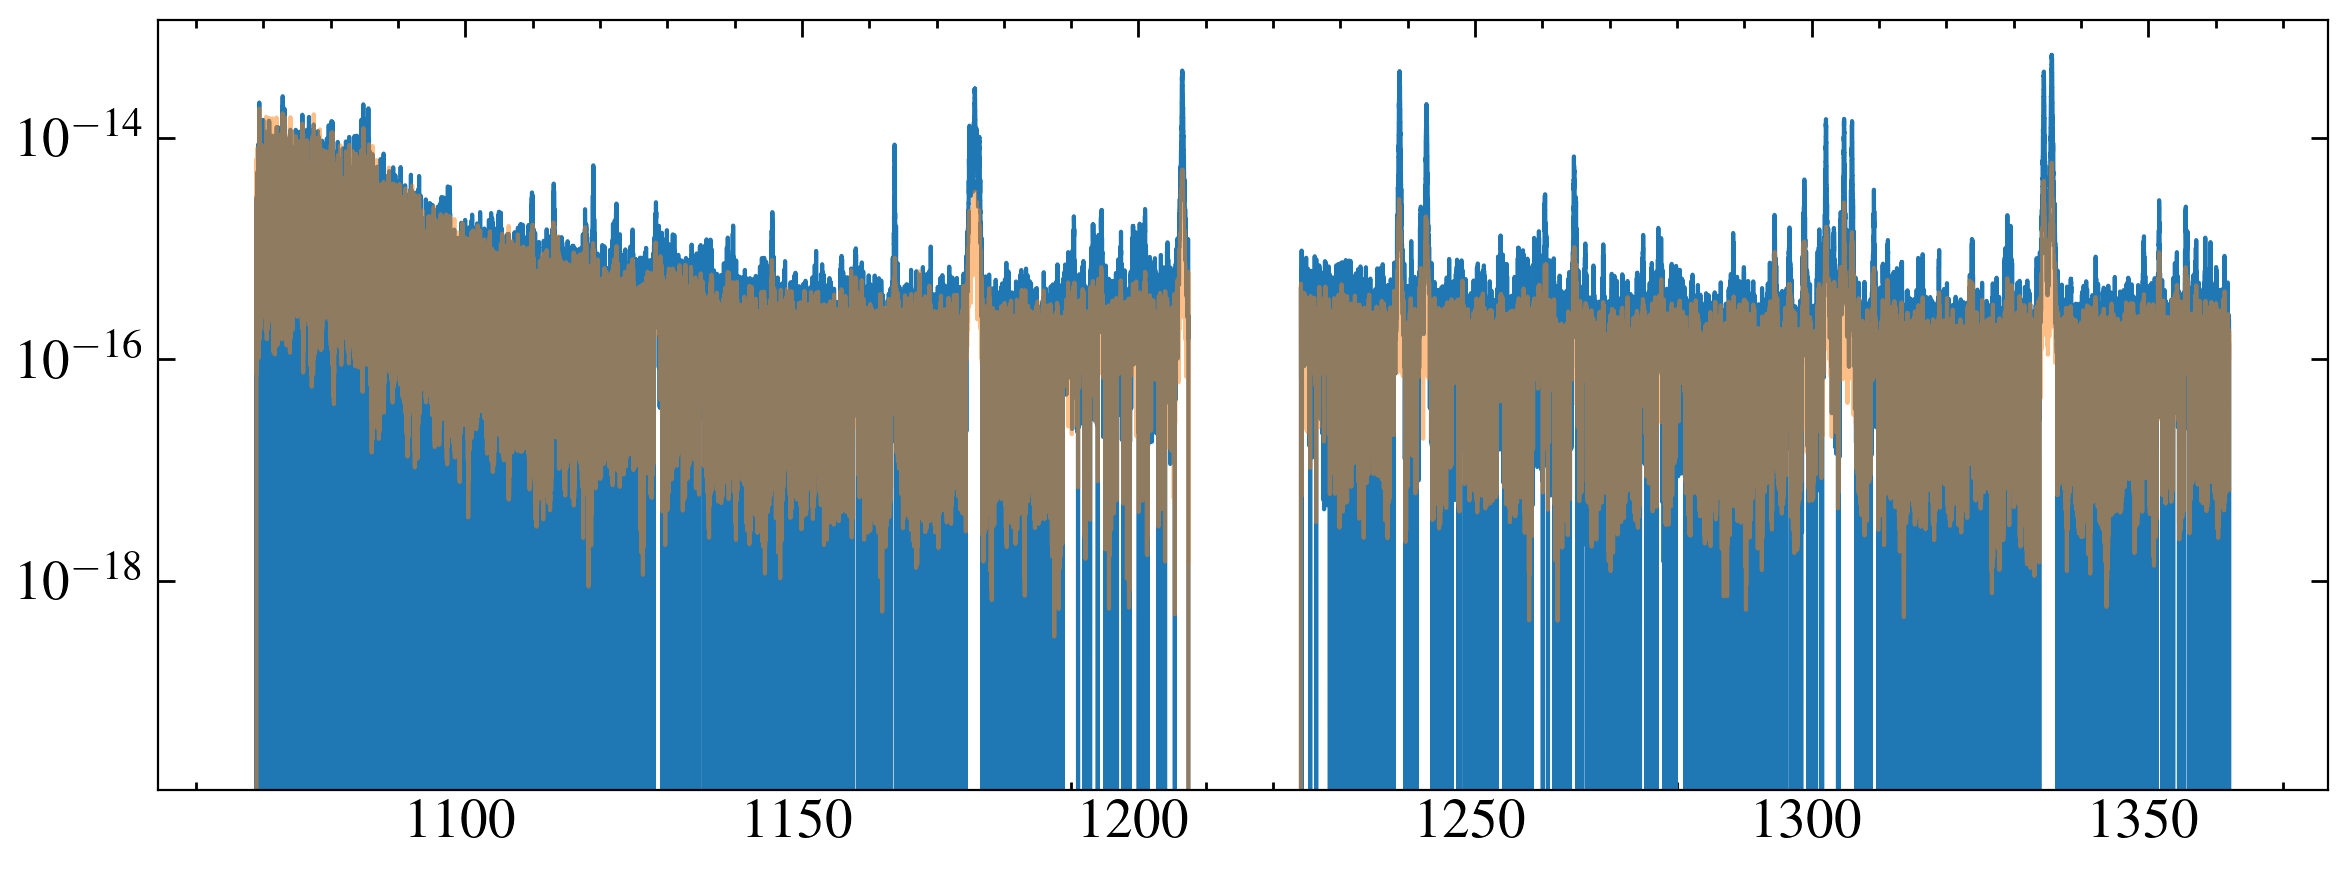

In [64]:
# fig, ax = plt.subplots()
gjpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj674/'
gx1ds = glob.glob('{}*x1d.fits'.format(gjpath))
for x in gx1ds:
    fig, ax = plt.subplots()
    
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    print(w[-1])
    ax.step(w, f, where='mid')
    ax.step(w, e, where='mid', alpha=0.5)
    ax.set_yscale('log')    
    plt.show()
    
    
for spec in flarespecs:
    w, f, e = np.loadtxt(spec, unpack=True, skiprows=1)
    fig, ax = plt.subplots()
    ax.step(w, f, where='mid')
    ax.step(w, e, where='mid', alpha=0.5)
    ax.set_yscale('log')    
    plt.show()
    

# ax.set_ylim(-0.1e-14, 1e-14)
# ax.set_yscale('log')

So it always had continummn? Something weird happening with the adapt errors 

In [65]:
hlsps

['draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g430l_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_model_lya_gj_367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_multi_multi_gj_367_broadband_v1_const-res-sed.fits',
 'draft_hlsp/gj_367/hlsp_muscles_multi_multi_gj_367_broadband_v1_var-res-sed.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_cos_gj_367_g130m_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_model_apec_gj_367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_model_phx_gj_367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_model_dem_gj_367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g230l_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_multi_multi_gj_367_broadband_v1_adapt-const-res-sed.fits',
 'draft_hlsp/gj_367/hlsp_muscles_xmm_epic_gj367_na_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscl

(-1e-15, 4e-15)

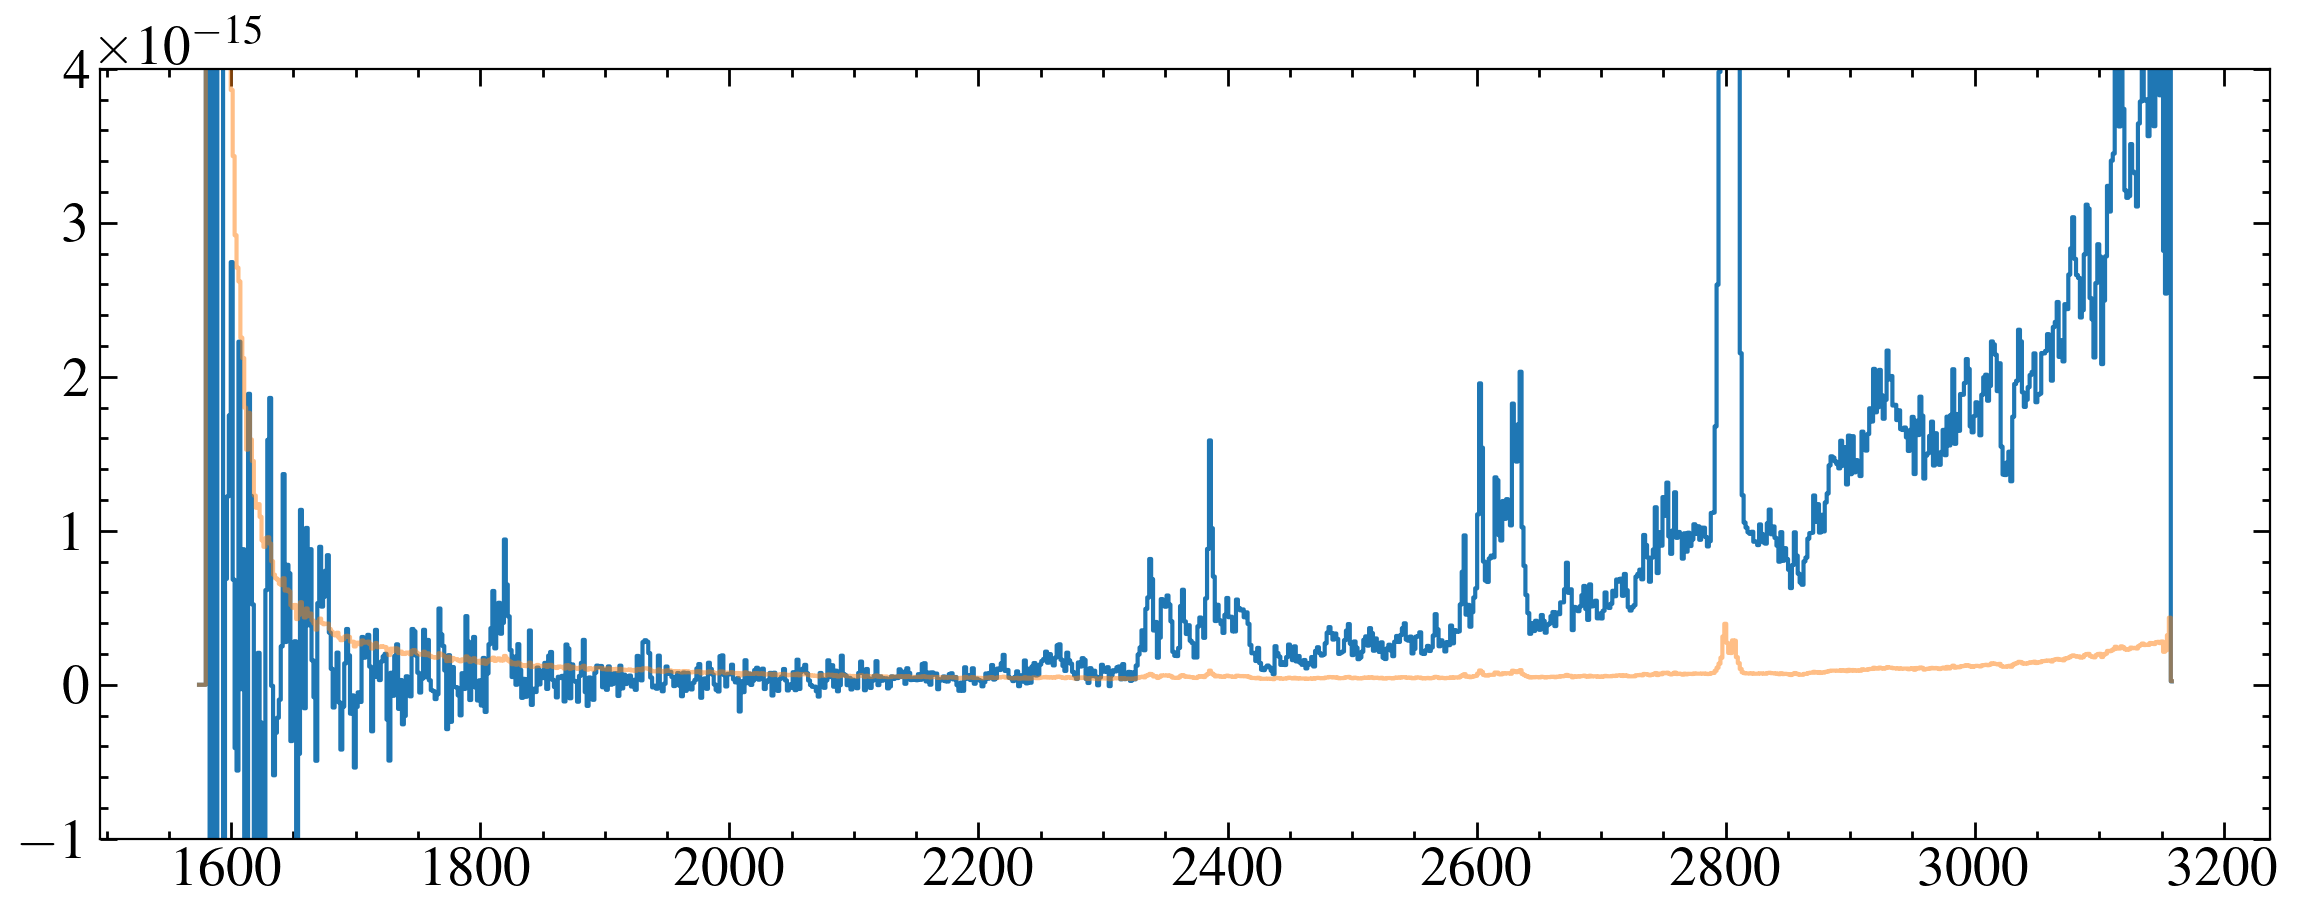

In [69]:
data = fits.getdata(hlsps[9], 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
# mask = w > 1100

plt.step(w, f, where='mid')
plt.step(w, e, where='mid', alpha=0.5)

plt.ylim(-0.1e-14, 0.4e-14)

In [84]:
import remove_negatives
importlib.reload(remove_negatives)

<module 'remove_negatives' from '/home/david/work/meats/SEDs/remove_negatives.py'>

In [85]:
wi, fi, ei = remove_negatives.remove_negatives(w, f, e)

(-1e-15, 4e-15)

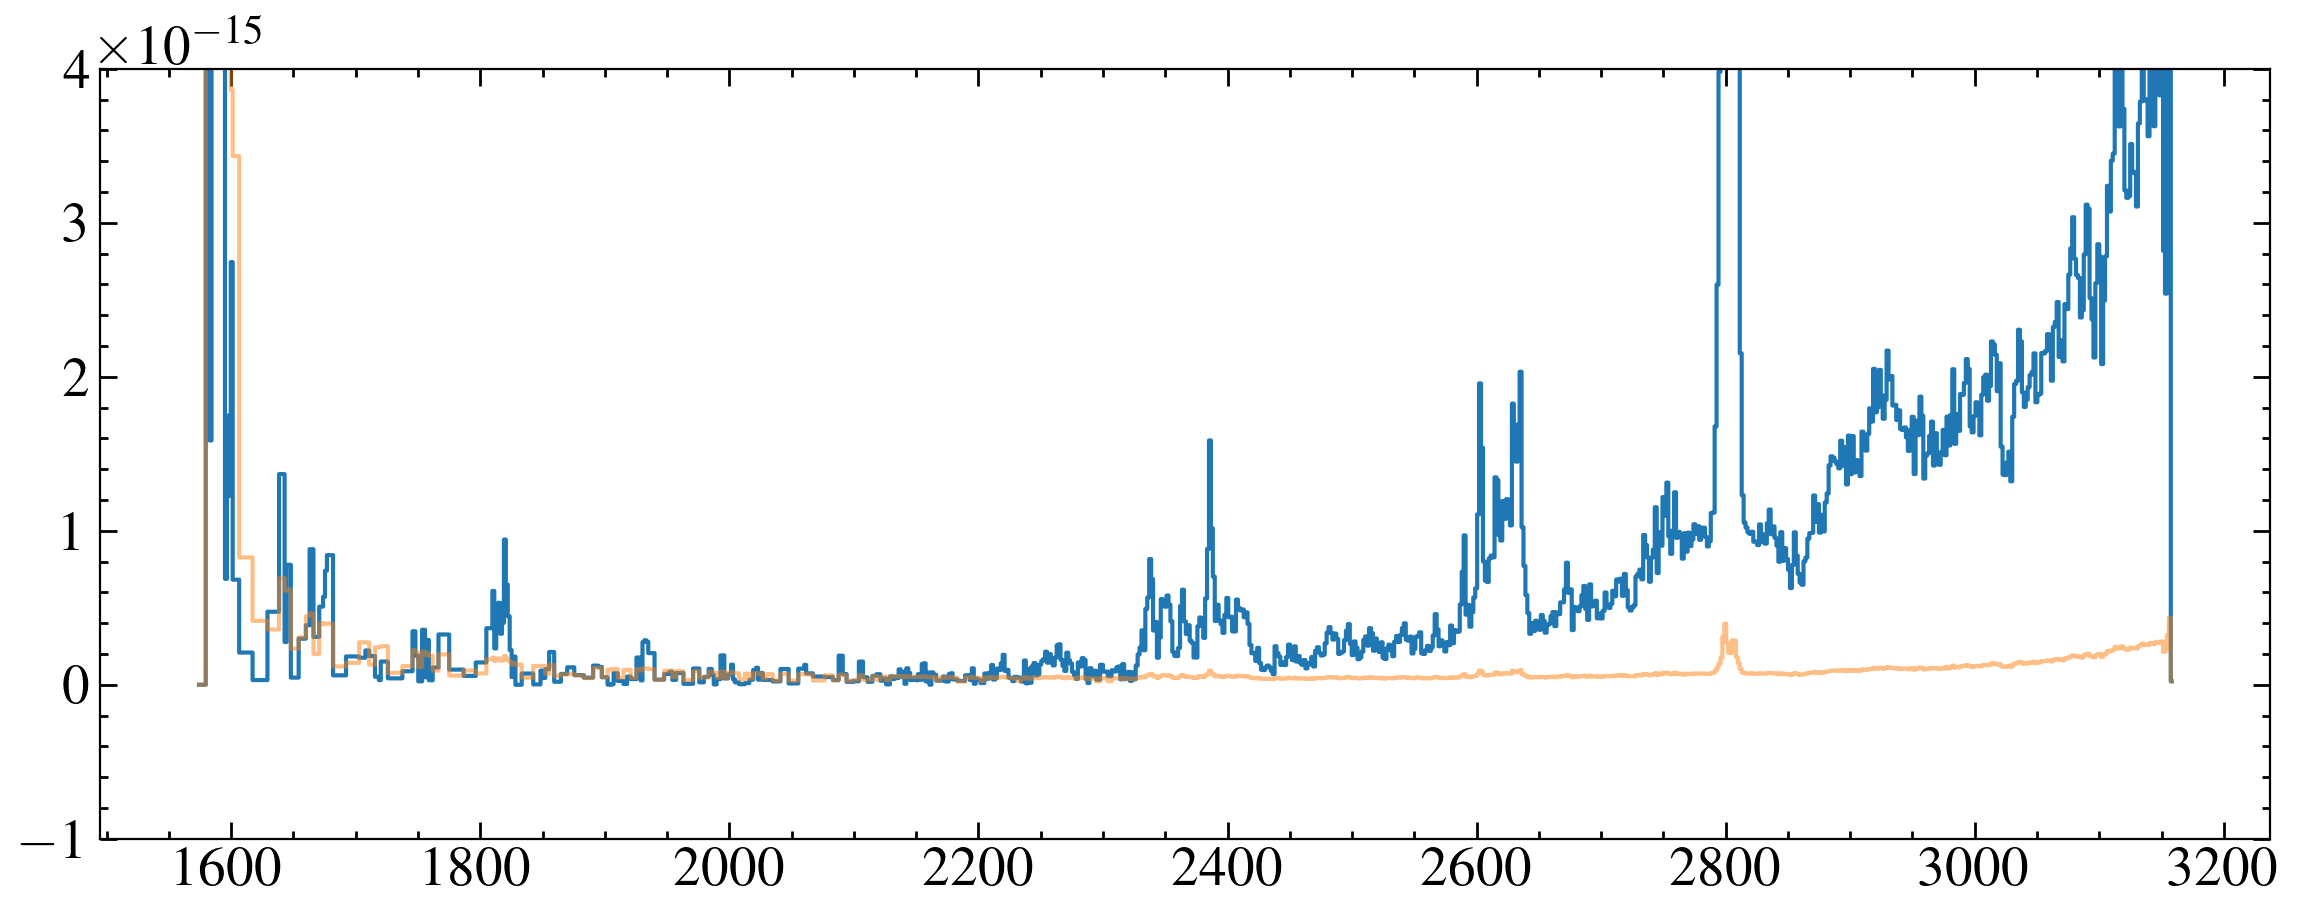

In [86]:
plt.step(wi, fi, where='mid')
plt.step(wi, ei, where='mid', alpha=0.5)

plt.ylim(-0.1e-14, 0.4e-14)



In [78]:
np.diff(w)

array([1.54374197, 1.54375103, 1.54376009, ..., 1.55306783, 1.55307706,
       1.55308628])

In [83]:
em = np.mean(e[(w > 1720) & (w < 2100)])
em

1.1523274e-16

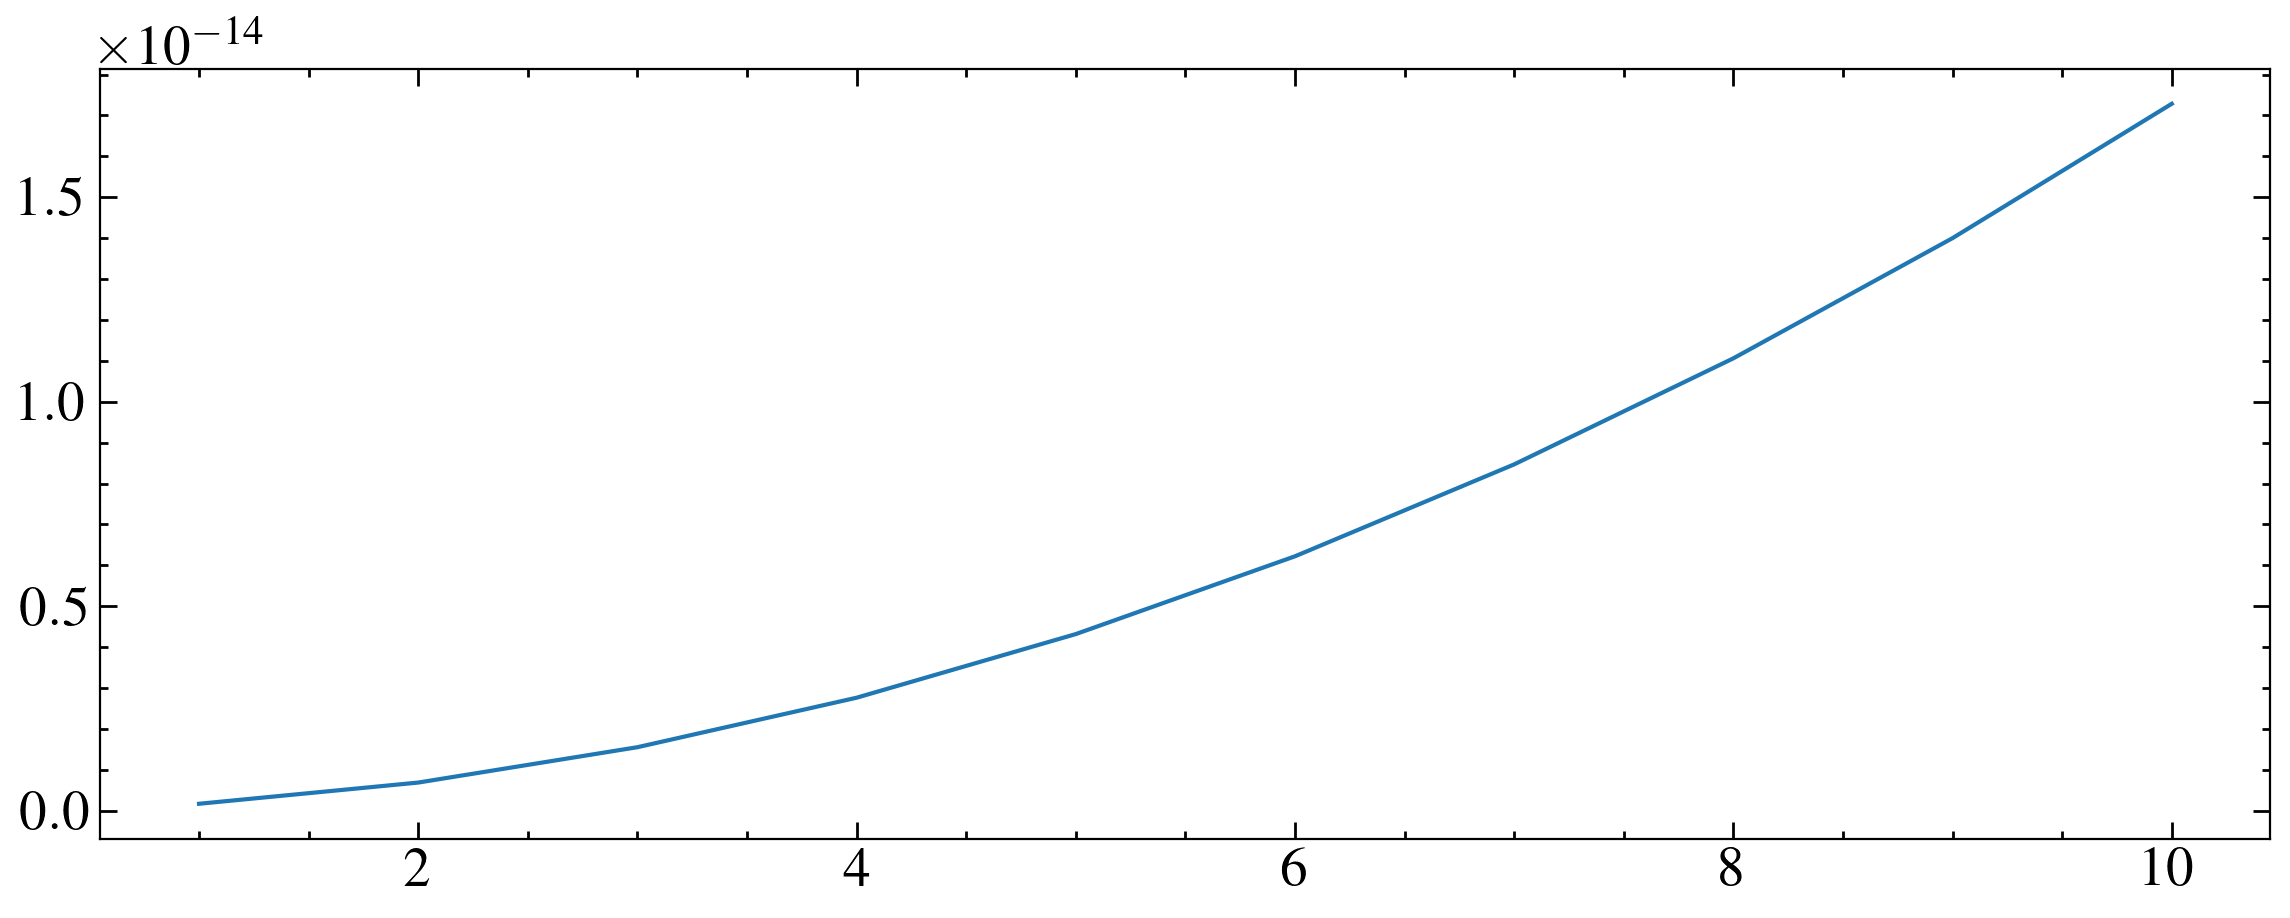

In [82]:
xaxis = np.arange(10)+1
errs = []
for i in xaxis:
    err = (((em*i)**2) * (1.5*i)**2)**0.5 
    errs.append(err)
plt.plot(xaxis, errs)

Ok issue was a bug in how remove negatives did error prop. Looks like we're done!